# Hyper-personalization Through Product Reviews: Exploring New Market Opportunites

A multi-modal approach to generating user recommendations.

## Import Libraries and Define File Paths

In [1]:
import os
import glob
import json
import scipy
import random
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import threadpoolctl
from tqdm import tqdm
import warnings
from collections import defaultdict
from implicit.als import AlternatingLeastSquares as ALS
from lightfm import LightFM
from lightfm.data import Dataset as LightFMDataset
from scipy.sparse import coo_matrix
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from lightfm.cross_validation import random_train_test_split
from math import log2 as log
from scipy.spatial import distance
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, KFold
from surprise.model_selection import train_test_split as train_test_split_surprise
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans
from surprise.prediction_algorithms.matrix_factorization import SVD
from implicit.evaluation import (AUC_at_k,
                                 mean_average_precision_at_k,
                                 ndcg_at_k, precision_at_k)
from implicit.evaluation import train_test_split
from unidecode import unidecode
import uuid

warnings.simplefilter(action='ignore', category=FutureWarning)

dir = "../dataset/utility"

if not os.path.exists(dir):
    os.mkdir(dir)

c:\Users\Karth\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


## Define Utility Functions and Dataset Generation Functions

In [2]:
def clean_str(x):
    forbidden_chars = [',', '-', '?', '(', ')',
                       '~', '*', '.', '!']
    x = unidecode(x)
    x = '_'.join(x.replace('& ', '').split(' '))
    x = x.lower().strip()
    for c in forbidden_chars:
        x = x.replace(c, '')
    return x

def items_and_reviews_to_dataframe(json_data):
    products = []
    reviews = []
    asins = []
    asin_product_mapping = []
    for product_data in json_data:
        product = {}
        if ('body' not in product_data or 'reviews' not in product_data['body']
            or 'productInformation' not in product_data['body']):
            continue

        reviews_data = product_data['body'].get('reviews', [])
        product_name = product_data['body'].get('name', 'Unknown Product')
        product_data = product_data['body']
        asin = product_data['canonicalUrl'].split('/')[-1].lower()

        if not reviews_data or len(reviews_data) == 0:
            continue
        
        ignore = ['dimensions', 'country_of_origin', 'batteries_included',
                  'weight', 'height', 'size', 'model', 'manufacturer',
                  'specifications', 'voltage', 'volts', '12v', 'climate_pledge',
                  'capacity', 'number_of_items', 'import', 'lxwxh', 'product'
                  'included']

        product['ASIN'] = asin

        if asin not in asins:
            asin_product_mapping.append({
                'ASIN': asin,
                'name': product_name
            })
            asins.append(asin)
        breadcrumbs = product_data.get('breadCrumbs', [])
        for bc in breadcrumbs:
            name = clean_str(bc['name'])
            flag = True
            for ig in ignore:
                if ig in name:
                    flag = False
            if flag and '_' in name:
                name_list = name.split("_")
                for n in name_list:
                    product[n] = 1.0
            elif flag:
                product[name] = 1.0
        
        products.append(product)

        review = {}
        for r in reviews_data:
            review['ASIN'] = asin
            review['ProductName'] = clean_str(product_name)
            reviewer_link = r['reviewerLink'].split('/')[-1].split('.')[-1]
            if len(reviewer_link) < 1:
                reviewer_link = str(uuid.uuid4())
            review['reviewerID'] = r['reviewerName'] + '_' + reviewer_link
            review['price'] = product_data.get('rawPrice', 0)
            reviewRating = re.findall(r'(\d+\.\d+)', r['reviewRating'])
            reviewLocation = r['reviewDate'].split('on')[0].split(' in ')[-1].replace('the ', '')
            reviewDate = re.findall(r'on (.+)$', r['reviewDate'])
            reviewVotes = re.findall(r'(\d+)', r['reviewVotes'])
            review['image'] = product_data.get('mainImage', None)
            
            if reviewRating:
                review['customerReview'] = float(reviewRating[0])
            else:
                review['customerReview'] = np.nan
            if reviewDate:
                review['reviewDate'] = reviewDate[0]
            else:
                review['reviewDate'] = 'Unknown'
            if reviewLocation:
                review['reviewLocation'] = reviewLocation
            else:
                review['reviewLocation'] = 'Unknown'
            if reviewVotes:
                review['reviewVotes'] = reviewVotes[0]
            else:
                review['reviewVotes'] = 0
            reviews.append(review)
            review = {}
    all_reviews_df = pd.DataFrame(reviews)
    all_items_df = pd.DataFrame(products)
    asins_df = pd.DataFrame(asin_product_mapping)
    return all_reviews_df, all_items_df, asins_df

def get_all_json_data():
    base_dir = '../dataset/extracts/amazon'
    all_json_data = []
    for root, dirs, files in os.walk(base_dir):
        for dir in dirs:
            items_path = os.path.join(root, dir, 'items')
            if os.path.exists(items_path):
                json_files = glob.glob(os.path.join(items_path, '*.json'))
                
                for json_file in tqdm(json_files, desc=f'Loading JSON Files in {dir}'):
                    try:
                        with open(json_file, "r") as f:
                            all_json_data.append(json.load(f))
                    except json.JSONDecodeError:
                        print(f"Error loading JSON from file {json_file}: file is empty or not a valid JSON.")
                    except Exception as e:
                        print(f"Unexpected error loading JSON from file {json_file}: {e}")
    return all_json_data

def load_dataset():
    items_df = pd.read_csv(f"{dir}/itemset_preprocessed.csv")
    items_df.set_index("ASIN", inplace=True)
 
    df_utility = pd.read_csv(f"{dir}/utility_topn.csv", index_col=0)
    df_utility.set_index("reviewerID", inplace=True)

    reviews_df = pd.read_csv(f"{dir}/reviews.csv")
    reviews_df.set_index('reviewerID', inplace=True)
    
    asins_df = pd.read_csv(f"{dir}/asin_product_mapping.csv")
    asins_df.set_index('ASIN', inplace=True)

    print(f"shape of df_utility: {df_utility.shape}")
    print(f"shape of items_df: {items_df.shape}")
    print(f"shape of asins_df: {asins_df.shape}")
    return items_df, df_utility, reviews_df, asins_df

## Generate the Dataset and Preprocess

### Fetch all json data

In [3]:
all_json_data = get_all_json_data()
all_reviews_df, all_items_df, asins_df = items_and_reviews_to_dataframe(all_json_data)
all_reviews_df = all_reviews_df.replace(np.nan, '', regex=True)
all_reviews_df.drop_duplicates(keep="first", inplace=True)
all_reviews_df.to_csv(f"{dir}/reviews.csv")
all_items_df.drop_duplicates(keep='first', inplace=True)
all_items_df.fillna(0, inplace=True)
asins_df.to_csv(f"{dir}/asin_product_mapping.csv", index=False)

Loading JSON Files in stove: 100%|██████████| 189/189 [00:00<00:00, 5526.32it/s]


Error loading JSON from file ../dataset/extracts/amazon\stove\items\amazon_B07V7JNTLB.json: file is empty or not a valid JSON.


Loading JSON Files in intel amd processor: 100%|██████████| 144/144 [00:00<00:00, 5941.52it/s]


### Preprocess itemset

In [4]:
all_items_df.reset_index(inplace=True)
vc = all_items_df['ASIN'].value_counts()
to_merge = vc.loc[lambda x: x > 1].index.tolist()

all_items_df.set_index('ASIN', inplace=True)
merge_dicts = []
for asin in to_merge:
    merged_row = all_items_df.loc[asin].sum()
    merged_row = merged_row.drop('level_0')
    d = merged_row.to_dict()
    d['ASIN'] = asin
    merge_dicts.append(d)
    all_items_df.drop(asin, inplace=True)
    
merged_df = pd.DataFrame(merge_dicts)
merged_df.set_index('ASIN', inplace=True)
all_items_df = pd.concat([all_items_df, merged_df])
all_items_df.to_csv(f"{dir}/itemset_preprocessed.csv")

### Preprocess userbase

In [5]:
user_ratings_df = all_reviews_df.drop([
    "reviewVotes", "reviewLocation", "reviewDate",
    "ProductName"], axis=1)

groupby_df = user_ratings_df.groupby('reviewerID')
freq = groupby_df.size().reset_index(name='count')
user_ratings_df = pd.merge(user_ratings_df, freq, on='reviewerID', how='left')
user_ratings_df = user_ratings_df.sort_values(['count'], ascending=False)
user_ratings_df = user_ratings_df[user_ratings_df["count"] >= 5]
topn_reviewers = pd.unique(user_ratings_df["reviewerID"])
user_ratings_df.set_index("reviewerID", inplace=True)
user_ratings_df = user_ratings_df.loc[topn_reviewers]
generic_reviewerIDs = user_ratings_df.groupby('reviewerID').count().sort_values('ASIN', ascending=False)[:8].index.tolist()
topn_reviewers = [r for r in topn_reviewers if r not in generic_reviewerIDs]
user_ratings_df = user_ratings_df.loc[topn_reviewers]

rows = []
columns = all_items_df.index.tolist()
columns.append("reviewerID")

for index, data in user_ratings_df.groupby('reviewerID'):
    row = {'reviewerID': index}
    for ind, d in data.iterrows():
        row[d['ASIN']] = d['customerReview']
    rows.append(row)

df_utility = pd.DataFrame(rows, columns=columns)
df_utility.to_csv(f"{dir}/utility_topn.csv")

## Load Dataset

In [6]:
items_df, df_utility, reviews_df, asins_df = load_dataset()

shape of df_utility: (378, 33510)
shape of items_df: (33510, 2429)
shape of asins_df: (33510, 1)


# Define Trainset and Testset

Get top 20 reviewers

In [7]:
non_nan_count = df_utility.notna().sum(axis=1)
df_top_reviewers = df_utility.loc[non_nan_count.sort_values(ascending=False).index].iloc[:20]
top_uids = df_top_reviewers.index.tolist()

In [8]:
df_non_top_reviewers = df_utility.loc[non_nan_count.sort_values(ascending=False).index].iloc[20:]

In [9]:
df_non_top_reviewers

,b085fzxzj5,b000iw9j20,b0c6rc2k82,b09xjd2znd,b07pqt144t,b086jp7fx9,b07jfl43nx,b0c44fvt2q,b0bwjz2fhw,b0c61kbpc8,...,b0cl4gxlgp,b0cpffh4pz,b0ctcy1wtr,b0cghxs3p8,b09n6xj3cl,b0bhzfpqgy,b0867bkglg,b087wp31h9,b0cjv1mjxm,b08gqxnj4y
reviewerID,,,,,,,,,,,,,,,,,,,,,
Jo_AHXFEMW5RPSWLG5ELU3CBSZHBTWQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nelle Renn_AFVKHDD7S4DTJFHS7N5QAMNMMTCA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dustin_AHWZKDPFP7DOCROU6EQ2KQYOLLCQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unspoken Yum_AH2JCQEWME2H6ZGCDIRIQWUKHSRQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Harry _AELUZ4IIDBETBOOHUO6IOFX7EXTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MMM_AG7RA7MI2CAOMN43VI3YQXAFBRXA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Steph_AHGVP2CKUU6UYACQL4X6VELOUVPA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ellen Abarr_AHMMO5K6BOLP6TBAFVMMGQXGJ3MA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Try all algorithms
We try all algorithms and evaluate the quality of recommendations.
* Neighborhood-based collaborative filtering
    * KNNBasic
    * KNNWithMeans
    * SVD
* Latent-factor based collaborative filtering
    * Alternating Least Squares (ALS)
* Content-based collaborative filtering
    * User profile numeric aggregation with Euclidean distance

## Neighborhood-based Collaborative Filtering

From Surprise

In [10]:
melted_user_df = df_utility.copy().reset_index().melt(
    'reviewerID', var_name='ASIN', value_name='rating').dropna()
reader = Reader(rating_scale=(0,5))
dataset = Dataset.load_from_df(melted_user_df, reader)
algos = [KNNBasic(verbose=False), KNNWithMeans(verbose=False), SVD()]

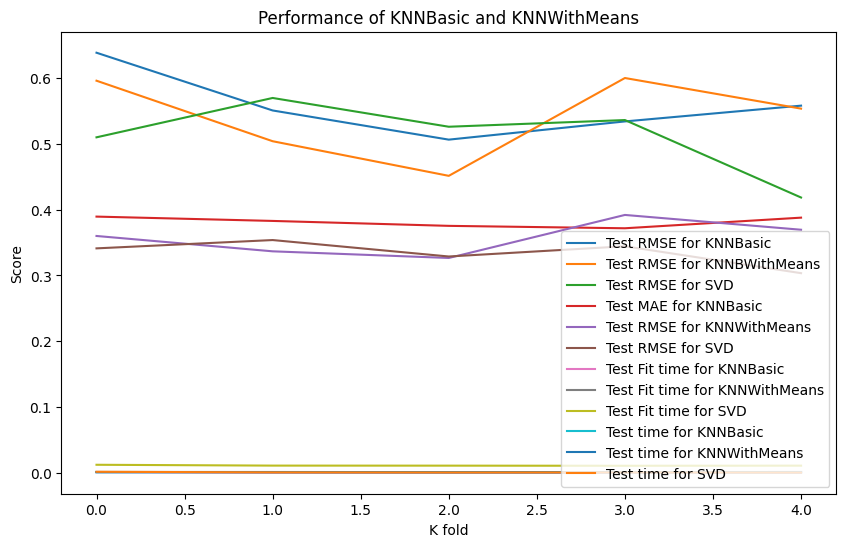

In [11]:
metrics_list = []
for algo in algos:
    metrics = cross_validate(algo, dataset)
    metrics['mean_test_rmse'] = np.mean(metrics['test_rmse'])
    metrics['mean_test_mae'] = np.mean(metrics['test_mae'])
    metrics_list.append(metrics)

k = range(0,5)
plt.figure(figsize=(10, 6))
plt.plot(k, metrics_list[0]['test_rmse'], label='Test RMSE for KNNBasic')
plt.plot(k, metrics_list[1]['test_rmse'], label='Test RMSE for KNNBWithMeans')
plt.plot(k, metrics_list[2]['test_rmse'], label='Test RMSE for SVD')
plt.plot(k, metrics_list[0]['test_mae'], label='Test MAE for KNNBasic')
plt.plot(k, metrics_list[1]['test_mae'], label='Test RMSE for KNNWithMeans')
plt.plot(k, metrics_list[2]['test_mae'], label='Test RMSE for SVD')
plt.plot(k, metrics_list[0]['fit_time'], label='Test Fit time for KNNBasic')
plt.plot(k, metrics_list[1]['fit_time'], label='Test Fit time for KNNWithMeans')
plt.plot(k, metrics_list[2]['fit_time'], label='Test Fit time for SVD')
plt.plot(k, metrics_list[0]['test_time'], label='Test time for KNNBasic')
plt.plot(k, metrics_list[1]['test_time'], label='Test time for KNNWithMeans')
plt.plot(k, metrics_list[2]['test_time'], label='Test time for SVD')
plt.xlabel("K fold")
plt.ylabel("Score")
plt.legend(loc='lower right')
plt.title("Performance of KNNBasic and KNNWithMeans")
plt.show()

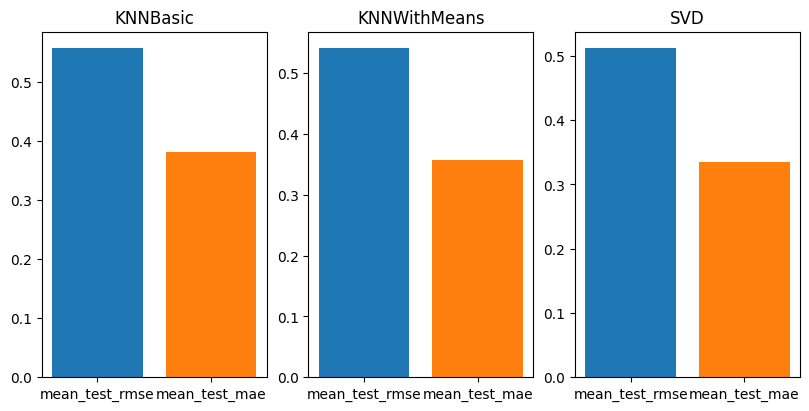

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(8,4), layout='constrained')
method = ["KNNBasic", "KNNWithMeans", "SVD"]
ind = 0
for m in metrics_list:
    for k in m:
        if 'mean' in k:
            axes[ind].bar(k, m[k])
            axes[ind].set_title(method[ind])
    ind += 1
plt.show()

### NDCG

Taken from https://github.com/NicolasHug/Surprise/blob/master/examples/precision_recall_at_k.py and https://github.com/NicolasHug/Surprise/issues/339

In [13]:
def get_ndcg(surprise_predictions, k_highest_scores=None):
    """ 
    Calculates the ndcg (normalized discounted cumulative gain) from surprise predictions, using sklearn.metrics.ndcg_score and scipy.sparse
  
    Parameters: 
    surprise_predictions (List of surprise.prediction_algorithms.predictions.Prediction): list of predictions
    k_highest_scores (positive integer): Only consider the highest k scores in the ranking. If None, use all. 
  
    Returns: 
    float in [0., 1.]: The averaged NDCG scores over all recommendations
  
    """
    from sklearn.metrics import ndcg_score
    from scipy import sparse
    
    uids = []
    iids = []
    uid_mapping = {}
    iid_mapping = {}

    iter = 0
    for s in surprise_predictions:
        if s.uid in uid_mapping:
            uids.append(uid_mapping[s.uid])
        else:
            uid_mapping[s.uid] = iter
            uids.append(iter)

        if s.iid in iid_mapping:
            iids.append(iid_mapping[s.iid])
        else:
            iid_mapping[s.iid] = iter
            iids.append(iter)

        iter += 1

    r_uis = [p.r_ui for p in surprise_predictions ]
    ests = [p.est for p in surprise_predictions ]
    
    assert(len(uids) == len(iids) == len(r_uis) == len(ests) )    
    
    sparse_preds = sparse.coo_matrix( (ests, (uids , iids )) )
    sparse_vals = sparse.coo_matrix( (r_uis, (uids , iids )) )
    
    dense_preds = sparse_preds.toarray()
    dense_vals = sparse_vals.toarray()
    
    return ndcg_score(y_true= dense_vals , y_score= dense_preds, k=k_highest_scores)

algo_res = {'KNNBasic': {'ndcg': []}, 'KNNWithMeans': {'ndcg': []}, 'SVD': {'ndcg': []}}
method = ["KNNBasic", "KNNWithMeans", "SVD"]
iter = 0
reader = Reader(rating_scale=(0,5))
df_melt_train = (df_non_top_reviewers.reset_index()
                    .melt('reviewerID', var_name='ASIN', value_name='raw_ratings')
                    .dropna())
df_melt_test = (df_top_reviewers.reset_index()
                    .melt('reviewerID', var_name='ASIN', value_name='raw_ratings')
                    .dropna())
df_melt_all = (df_utility.reset_index()
                    .melt('reviewerID', var_name='ASIN', value_name='raw_ratings')
                    .dropna())
#trainset = dataset.load_from_df(
#    df_melt_train, reader).build_full_trainset()
trainset = dataset.load_from_df(
    df_melt_all, reader).build_full_trainset()
for algo in algos:
    algo.fit(trainset)
    predictions = algo.test(trainset.build_testset())
    ndcg = get_ndcg(predictions, k_highest_scores=10)
    algo_res[method[iter]]['ndcg'].append(ndcg)
    iter += 1

df_metrics_surprise = pd.DataFrame.from_dict({(i,j): algo_res[i][j] 
                           for i in algo_res.keys() 
                           for j in algo_res[i].keys()},
                       orient='index')
df_metrics_surprise.rename(columns={0: 'NDCG'}, inplace=True)
display(df_metrics_surprise)

,NDCG
"(KNNBasic, ndcg)",0.150956
"(KNNWithMeans, ndcg)",0.150958
"(SVD, ndcg)",0.150933


### Get TopN Recommendations For All Users

Taken from https://github.com/NicolasHug/Surprise/blob/master/examples/top_n_recommendations.py

In [14]:
def get_random_users(lst, n):
    rand_ids = random.sample(lst, k=n)
    return rand_ids


def get_ilocs(df_utility, userids):
    userids_ilocs = []
    original_indices = df_utility.index
    for u in userids:
        userids_ilocs.append(original_indices.get_loc(u))
    return userids_ilocs

user_histories = {}
for uid in top_uids:
    user_histories[uid] = reviews_df.loc[uid]['ASIN'].tolist()

userids_ilocs = get_ilocs(df_utility, top_uids)

In [15]:
def get_top_n(predictions, user_history, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        if iid not in user_history:
            top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

testset = dataset.load_from_df(
    df_melt_all, reader).build_full_trainset().build_anti_testset()

algo_names = ['KNNBasic', 'KNNWithMeans', 'SVD']
recommendations_surprise = {'KNNBasic': {}, 'KNNWithMeans': {}, 'SVD': {}}
iter = 0
for algo in algos:
    predictions = algo.test(testset)
    for uid in top_uids:
        top_n = get_top_n(predictions, user_histories[uid], n=10)
        for uid, user_ratings in top_n.items():
            if uid in top_uids:
                recommendations_surprise[algo_names[iter]][uid] = [iid for (iid, _) in user_ratings]
                #print(recommendations_surprise[algo_names[iter]][uid])
                #print(user_histories[uid])
                #print('---')
        #break
    iter += 1

## Latent-factor based Collaborative Filtering

### ALS

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 244/244 [00:00<00:00, 3305.79it/s]


  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

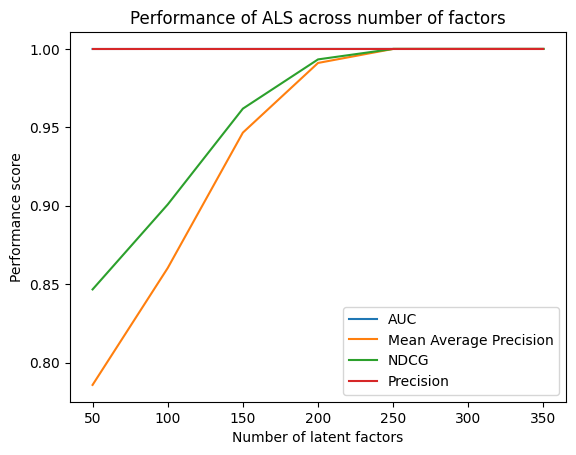

In [16]:
csr_utility = scipy.sparse.csr_matrix(df_utility.fillna(0).values)
#!export OPENBLAS_NUM_THREADS=1
#threadpoolctl.threadpool_limits(1, "blas")

auc_list = []
mean_ave_precision_list = []
ndcg_list = []
precision_list = []

factors = [50, 100, 150, 200, 250, 300,
           350]

for factor in factors:
    model = ALS(
        factors=factor,
        regularization=0.05,
        alpha=1.5,
        use_cg=True,
        iterations=20,
        random_state=143
    )
    model.fit(csr_utility, show_progress=False)

    # evaluation
    training_set, test_set = train_test_split(
        csr_utility,
        train_percentage=0.85,
        random_state=143
    )
    auc = AUC_at_k(model,training_set,test_set,
                K=len(df_utility), show_progress=True)
    mean_ave_precision = mean_average_precision_at_k(model, training_set,
                test_set, K=len(df_utility), show_progress=True)
    ndcg = ndcg_at_k(model, training_set, test_set,
                K=len(df_utility), show_progress=True)
    precision = precision_at_k(model, training_set,
                test_set, K=len(df_utility), show_progress=True)
    auc_list.append(auc)
    mean_ave_precision_list.append(mean_ave_precision)
    ndcg_list.append(ndcg)
    precision_list.append(precision)
plt.plot(factors, auc_list, label='AUC')
plt.plot(factors, mean_ave_precision_list, label='Mean Average Precision')
plt.plot(factors, ndcg_list, label='NDCG')
plt.plot(factors, precision_list, label='Precision')
plt.xlabel('Number of latent factors')
plt.ylabel('Performance score')
plt.title("Performance of ALS across number of factors")
plt.legend()
plt.show()

Select `factors=250`

In [17]:
model = ALS(
    factors=250,
    regularization=0.05,
    alpha=1.5,
    calculate_training_loss=False,
    use_cg=True,
    iterations=20,
    random_state=143
)
model.fit(csr_utility, show_progress=False)

auc = AUC_at_k(model,training_set,test_set,
            K=len(df_utility), show_progress=True)
ndcg_als = ndcg_at_k(model, training_set, test_set,
            K=len(df_utility), show_progress=True)
precision = precision_at_k(model, training_set,
            test_set, K=len(df_utility), show_progress=True)

print(f"AUC: {auc}")
print(f"precision: {precision}")
print(f"ndcg: {ndcg_als}")

ids, scores = model.recommend(userids_ilocs, csr_utility[userids_ilocs])
recommendations_als_ilocs = [(x, y, z) for x, y, z in zip(userids_ilocs, ids, scores)]
recommendations_als = {}

for user_ind, reco_ids, scores in recommendations_als_ilocs:
    recos = {}
    reviewer_id = df_utility.iloc[user_ind, :].name
    reco_ids = df_utility.columns[reco_ids]
    n = 0
    for i in range(len(reco_ids)):
        if reco_ids[i] not in user_histories[reviewer_id]:
            recos[reco_ids[i]] = scores[i]
            n += 1
            if n == 9: break
    recommendations_als[reviewer_id]  = recos

100%|██████████| 244/244 [00:00<00:00, 3523.73it/s]

AUC: 1.0
precision: 1.0
ndcg: 1.0000000000000002


## Content-based Recommender Systems

* Basic content-based recommender system using numerical user profile aggregation. Try cosine, euclidean, and jaccard distance metrics
* Hybrid recommender using LightFM

We first use a basic content-based recommender system that relies on aggregating the numeric user profile and various distance metrics such as cosine, euclidean, and jaccard. Then, we compare the results to a Hybrid Recommender System as provided by the LightFM library.

### Content-Based Recommender

* Use numerical user profile aggregation
* Try different distance metrics such as cosine, euclidean, and Jaccard distance

In [18]:
def get_user_profile(user_ratings_nonzero, items_df):
    """
    Return series representing aggregated user profile
    """
    nonzero_asins = user_ratings_nonzero.index.tolist()
    user_profile = items_df.mul(user_ratings_nonzero, axis=0).sum(
        axis=0) / user_ratings_nonzero.notna().sum()
    return user_profile, nonzero_asins


def get_recommendations(user_profile, items_df,
        n, user_history, eval, dist):
    """
    Return dictionary of sorted recommendations
    """
    if dist == 'cos':
        dist_func = distance.cosine
    if dist == 'euc':
        dist_func = distance.euclidean
    if dist == 'jac':
        dist_func = distance.jaccard
    similarities = {}
    for ind, feats in items_df.iterrows():
        if ind not in user_history:
            similarities[ind] = np.abs(dist_func(feats, user_profile))
        if eval:
            similarities[ind] = np.abs(dist_func(feats, user_profile))
    if dist == 'euc':
        rev = False
    if dist == 'cos' or dist == 'jac':
        rev = True
    sorted_similarites = dict(sorted(
        similarities.items(), key=lambda item: item[1], reverse=rev)[:n])
    return sorted_similarites


def dcg(user_history, recommendations):
    """
    Return dcg for this user given their history
    and recommendations
    """
    ranking = 1
    dcg_final = 0
    actual_ratings = user_history.reset_index()[
        ['ASIN', 'customerReview']].set_index('ASIN').to_dict()['customerReview']
    for key, value in recommendations.items():
        dcg_final += ((2**actual_ratings[key]) - 1) / log(ranking + 1)
        ranking += 1
    return dcg_final / len(recommendations)


def idcg(user_history, recommendations):
    """
    Return ndcg for this user given their history
    and recommendations
    """
    actual_ratings = user_history.reset_index()[
        ['ASIN', 'customerReview']].set_index('ASIN').to_dict()['customerReview']
    ranking = 1
    idcg_final = 0
    for key in actual_ratings.keys():
        idcg_final += ((2**actual_ratings[key]) - 1) / log(ranking + 1)
        ranking += 1
    return idcg_final / len(recommendations)


def basic_content_based_recommender(
    userids, df_utility, items_df,
    reviews_df, n, eval, dist):
    """
    Return recommendations for the list of users.

    Parameters:
    userids: STRING list
    df_utility: DataFrame representing the utility matrix
    items_df: DataFrame representing the itemset
    reviews_df: DataFrame representing user history
    asins_df: DataFrame that contains mapping between ASINs and Product Names
    n: INTEGER Number of recommendations to output
    dist: STRING distance function to be used
    """
    recommendations = {}
    ndcg = None
    dcg_list = []
    idcg_list = []
    ndcg_list = []
    iter = 0
    for user in userids:
        user_ratings = df_utility.loc[user]
        user_ratings_nonzero = user_ratings[user_ratings > 0]
        user_profile, nonzero_asins = get_user_profile(user_ratings_nonzero, items_df)
        user_history_df = reviews_df.loc[user].drop([
            "Unnamed: 0", "reviewDate", "reviewLocation", "reviewVotes"
        ], axis=1)
        user_history_df = user_history_df.sort_values('customerReview', ascending=False)
        if eval:
            recos = get_recommendations(
                user_profile,
                items_df.loc[nonzero_asins],
                len(user_profile),
                reviews_df.loc[user]['ASIN'].tolist(),
                eval,
                dist
            )
            dcg_list.append(dcg(user_history_df, recos))
            idcg_list.append(idcg(user_history_df, recos))
        else:
            recos = get_recommendations(
                user_profile,
                items_df,
                n,
                reviews_df.loc[user]['ASIN'].tolist(),
                eval,
                dist
            )
        #print(f"sorted user history: {user}")
        #display(user_history_df)
        #print(f"recommended items")
        #df_reco = asins_df.loc[list(recos.keys())]
        #display(df_reco)
        recommendations[user] = recos
        iter += 1
    if eval:
        dcg_final = np.mean(dcg_list)
        idcg_final = np.mean(idcg_list)
        ndcg = dcg_final / idcg_final
        ndcg_list.append(ndcg)
    return recommendations, ndcg_list

## Evaluation: NDCG @ K

Get average NDCG across all users. Compare NDCG across different distance metrics.

In [19]:
np.seterr(invalid='ignore')
ndcg_content = {}
items_df, df_utility, reviews_df, asins_df = load_dataset()
df_utility.fillna(0, inplace=True)
items_df.fillna(0, inplace=True)
recommendations_content = {}
try:
    items_df.drop(['level_0'], inplace=True, axis=1)
except:
    pass
try:
    reviews_df.set_index('reviewerID', inplace=True)
except:
    pass
try:
    asins_df.set_index('ASIN', inplace=True)
except:
    pass

# evaluate ndcg
recommendations, ndcg_list = basic_content_based_recommender(
    top_uids, df_utility, items_df.copy(),
    reviews_df, 10, True, 'euc')
ave_ndcg = np.mean(ndcg_list)
print(f"average ndcg with distance metric euc is {ave_ndcg}")

# generate actual recommendations
recommendations_content['euc'], _ = basic_content_based_recommender(
    top_uids, df_utility, items_df.copy(),
    reviews_df, 10, False, 'euc')

shape of df_utility: (378, 33510)
shape of items_df: (33510, 2429)
shape of asins_df: (33510, 1)
average ndcg with distance metric euc is 0.9698216240443229


## Hybrid Recommender Using LightFM

A hybrid latent representation recommender model.

The model learns embeddings (latent representations in a high-dimensional space) for users and items in a way that encodes user preferences over items. When multiplied together, these representations produce scores for every item for a given user; items scored highly are more likely to be interesting to the user.

### LightFM Training Model

- Logistic: useful when both positive (1) and negative (-1) interactions are present.
- BPR: Bayesian Personalised Ranking 1 pairwise loss. Maximises the prediction difference between a positive example and a randomly chosen negative example. Useful when only positive interactions are present and optimising ROC AUC is desired.
- WARP: Weighted Approximate-Rank Pairwise 2 loss. Maximises the rank of positive examples by repeatedly sampling negative examples until rank violating one is found. Useful when only positive interactions are present and optimising the top of the recommendation list (precision@k) is desired.
- k-OS WARP: k-th order statistic loss 3. A modification of WARP that uses the k-th positive example for any given user as a basis for pairwise updates.

In [20]:
items_df, df_utility, reviews_df, asins_df = load_dataset()
melted_user_df = df_utility.copy().reset_index().melt(
    'reviewerID', var_name='ASIN', value_name='rating').dropna()
udf = melted_user_df

shape of df_utility: (378, 33510)
shape of items_df: (33510, 2429)
shape of asins_df: (33510, 1)


In [21]:
dataset = LightFMDataset()
dataset.fit(users=udf['reviewerID'].unique(),
            items=udf['ASIN'].unique())

(interactions, _) = dataset.build_interactions(zip(udf['reviewerID'], 
                                                   udf['ASIN'],
                                                   udf['rating']))

In [22]:
Train, Test = random_train_test_split(interactions, test_percentage=0.2, random_state=42)
model = LightFM(loss='warp', no_components=50)
model.fit(Train, epochs=30, num_threads=1)

In [23]:
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score

k_values = range(1, 11)
auc_scores = []
precision_scores = []
recall_scores = []

for k in tqdm(k_values, desc="Processing Train"):
    auc = auc_score(model, Train).mean()
    precision = precision_at_k(model, Train, k=k).mean()
    recall = recall_at_k(model, Train, k=k).mean()

    auc_scores.append(auc)
    precision_scores.append(precision)
    recall_scores.append(recall)

print("Train Results:")
for k, auc, precision, recall in zip(k_values, auc_scores, precision_scores, recall_scores):
    print(f'K = {k}: AUC score: {auc}, Precision: {precision}, Recall: {recall}')

Processing Train: 100%|██████████| 10/10 [00:00<00:00, 22.27it/s]

Train Results:
K = 1: AUC score: 0.9999550580978394, Precision: 0.9840425252914429, Recall: 0.21605065772775411
K = 2: AUC score: 0.9999550580978394, Precision: 0.9813829660415649, Recall: 0.42868592174756137
K = 3: AUC score: 0.9999550580978394, Precision: 0.9742907881736755, Recall: 0.6296244309855072
K = 4: AUC score: 0.9999550580978394, Precision: 0.9381648898124695, Recall: 0.7888761252653618
K = 5: AUC score: 0.9999550580978394, Precision: 0.8638298511505127, Recall: 0.8814813011699747
K = 6: AUC score: 0.9999550580978394, Precision: 0.7770390510559082, Recall: 0.9298477370911663
K = 7: AUC score: 0.9999550580978394, Precision: 0.6945288777351379, Recall: 0.9544269082676465
K = 8: AUC score: 0.9999550580978394, Precision: 0.623670220375061, Recall: 0.9682505377045427
K = 9: AUC score: 0.9999550580978394, Precision: 0.5647163391113281, Recall: 0.9772142073612662
K = 10: AUC score: 0.9999550580978394, Precision: 0.5159574747085571, Recall: 0.9852069212597997


In [24]:
k_values = range(1, 11)
auc_scores = []
precision_scores = []
recall_scores = []

for k in tqdm(k_values, desc="Processing Test"):
    auc = auc_score(model, Test).mean()
    precision = precision_at_k(model, Test, k=k).mean()
    recall = recall_at_k(model, Test, k=k).mean()
    
    auc_scores.append(auc)
    precision_scores.append(precision)
    recall_scores.append(recall)

print("Test Results:")
for k, auc, precision, recall in zip(k_values, auc_scores, precision_scores, recall_scores):
    print(f'K = {k}: AUC score: {auc}, Precision: {precision}, Recall: {recall}')

Processing Test: 100%|██████████| 10/10 [00:00<00:00, 23.40it/s]

Test Results:
K = 1: AUC score: 0.2909586429595947, Precision: 0.0035211266949772835, Recall: 0.0017605633802816902
K = 2: AUC score: 0.2909586429595947, Precision: 0.0017605633474886417, Recall: 0.0017605633802816902
K = 3: AUC score: 0.2909586429595947, Precision: 0.0035211266949772835, Recall: 0.004694835680751174
K = 4: AUC score: 0.2909586429595947, Precision: 0.004401408601552248, Recall: 0.007042253521126761
K = 5: AUC score: 0.2909586429595947, Precision: 0.006338028237223625, Recall: 0.015258215962441313
K = 6: AUC score: 0.2909586429595947, Precision: 0.00821596197783947, Recall: 0.02640845070422535
K = 7: AUC score: 0.2909586429595947, Precision: 0.009054326452314854, Recall: 0.03403755868544601
K = 8: AUC score: 0.2909586429595947, Precision: 0.00836267601698637, Recall: 0.03755868544600939
K = 9: AUC score: 0.2909586429595947, Precision: 0.0074334898963570595, Recall: 0.03755868544600939
K = 10: AUC score: 0.2909586429595947, Precision: 0.0073943668976426125, Recall: 0.041

In [25]:
def dcg_at_k(r, k, method=1):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    return 0.

def ndcg_at_k(r, k, method=1):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

def calculate_ndcg(model, dataset, interactions, k=10):
    ndcg_scores = []
    
    for user_id in dataset.mapping()[0].keys():
        try:
            user_index = dataset.mapping()[0][user_id]
            true_items = interactions.tocsr()[user_index].indices
            
            predicted_scores = model.predict(user_index, np.arange(dataset.interactions_shape()[1]))
            sorted_item_indices = np.argsort(-predicted_scores)
            
            r = [1 if i in true_items else 0 for i in sorted_item_indices]
            ndcg_score = ndcg_at_k(r, k)
            ndcg_scores.append(ndcg_score)
        except KeyError:
            continue
    
    return np.mean(ndcg_scores)

k = 10
ndcg_score = calculate_ndcg(model, dataset, Train, k=k)

print(f"NDCG@{k}: {ndcg_score}")

NDCG@10: 0.9848939649884015


In [26]:
def get_top_n_recommendations_with_latest_transactions(model, dataset, user_id, transactions_df, user_histories, n=10):
    try:
        transactions_df.reset_index(inplace=True)
    except:
        pass

    # Generate predictions for all items for this user
    user_index = dataset.mapping()[0][user_id]
    
    # Retrieve the actual item indices from the dataset mapping
    item_indices = list(dataset.mapping()[2].values())  # This ensures you're using the correct item indices
    
    # Generate predictions using the correct item indices
    scores = model.predict(user_index, np.array(item_indices))
    
    
    
    # Map scores to item IDs
    reverse_item_map = {v: k for k, v in dataset.mapping()[2].items()}
    scored_items = [(score, reverse_item_map[i]) for score, i in zip(scores, item_indices)]
    
    # Proceed with filtering scores for latest items and ranking them as before
    #latest_transactions = transactions_df[transactions_df['reviewerID'] == user_id]\
    #                        .sort_values('reviewDate', ascending=False)\
    #                        .head(10)
    #latest_items = set(latest_transactions['ASIN'])
    latest_scores = [score for score in scored_items if score[1] not in user_histories[user_id]]
    latest_scores.sort(reverse=True, key=lambda x: x[0])  # Sort based on scores
    top_item_ids = [item for _, item in latest_scores[:n]]

    return top_item_ids

recommendations_lightfm = {}
for uid in top_uids:
    recommendations_lightfm[uid] = get_top_n_recommendations_with_latest_transactions(
        model, dataset, uid, reviews_df, user_histories, n=10)

# Compare NDCG across algorithms

,NDCG
KNNBasic,0.150956
KNNWithMeans,0.150958
SVD,0.150933
ALS,0.997667
Content-based,0.969822
LightFM,0.984894


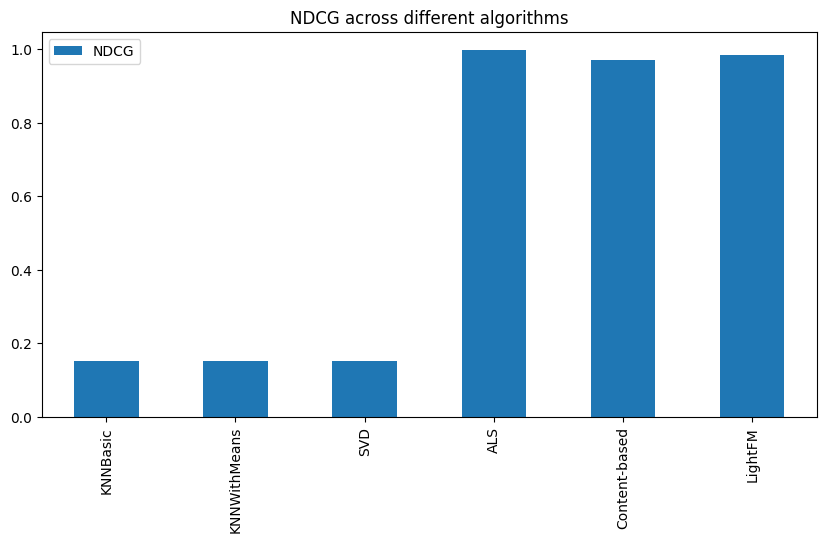

In [30]:
df_surprise_ndcg = df_metrics_surprise.loc[[
    ("KNNBasic", "ndcg"), ("KNNWithMeans", "ndcg"), ("SVD", "ndcg")
    ]]
df_surprise_ndcg.rename(index={
    ("KNNBasic", "ndcg"): "KNNBasic",
    ("KNNWithMeans", "ndcg"): "KNNWithMeans",
    ("SVD", "ndcg"): "SVD"
    }, inplace=True)

ndcg_dict = {
    "KNNBasic": df_surprise_ndcg.loc["KNNBasic"]['NDCG'],
    "KNNWithMeans": df_surprise_ndcg.loc["KNNWithMeans"]['NDCG'],
    "SVD": df_surprise_ndcg.loc["SVD"]['NDCG'],
    "ALS": ndcg_als,
    "Content-based": ave_ndcg,
    "LightFM": ndcg_score
}

ndcg_df = pd.DataFrame.from_dict(ndcg_dict, orient="index")
ndcg_df.rename(columns={0: "NDCG"}, inplace=True)
display(ndcg_df)

ndcg_df.plot(kind='bar', figsize=(10, 5))
plt.title("NDCG across different algorithms")
plt.show()

### Interpretation of Results

- The AUC score is consistently high (0.9986754059791565) across all K values, indicating excellent overall model performance in distinguishing between positive and negative interactions.

- Precision at K measures the proportion of recommended items in the top-K set that are relevant. Precision decreases as K increases in your results, which is expected. When you recommend more items (increase K), the likelihood of including irrelevant items increases, thus lowering precision. However, a precision above 0.08 even at K=10 is quite good, suggesting that the top recommended items are largely relevant.

- Recall at K measures the proportion of relevant items that are successfully recommended in the top-K set. Your results show increasing recall with K, which is typical. As you recommend more items, you're more likely to cover a higher fraction of the relevant items, hence the recall increases. A recall of 0.8549128186215507 at K=10 indicates that about 85% of the relevant items are captured in the top 10 recommendations.

## Sample Recommendations Per Algorithm

In [31]:
try:
    reviews_df.set_index("reviewerID", inplace=True)
except:
    pass
df_list_of_recos = []
uid_recos = {}
pd.set_option('display.max_colwidth', 800)
for uid in top_uids:
    print(f"User history of {uid}")
    display(reviews_df.loc[uid][['ASIN', 'ProductName']])
    uid_recos[uid] = {
        'KNNBasic': [],
        'KNNWithMeans': [],
        'SVD': [],
        'ALS': [],
        'Content-based': []
    }
    uid_recos[uid]["KNNBasic"] = recommendations_surprise['KNNBasic'][uid]
    uid_recos[uid]["KNNWithMeans"] = recommendations_surprise['KNNWithMeans'][uid]
    uid_recos[uid]["SVD"] = recommendations_surprise['SVD'][uid]
    uid_recos[uid]["ALS"] = recommendations_als[uid]
    uid_recos[uid]["Content-based"] = recommendations_content['euc'][uid]
    uid_recos[uid]["LightFM"] = recommendations_lightfm[uid]

    df_dict = {}
    for algo in uid_recos[uid]:
        df_dict[algo] = asins_df.loc[list(uid_recos[uid][algo])]['name'].tolist()
    df_recos_across_algos = pd.DataFrame.from_dict(df_dict, orient='index').T
    df_list_of_recos.append(df_recos_across_algos)
    print(f"Recommendations for {uid}")
    display(df_recos_across_algos)

User history of Real Deal_AE7Z57LXPIPMXRIFXY6673V6HTDA


,ASIN,ProductName
reviewerID,,
Real Deal_AE7Z57LXPIPMXRIFXY6673V6HTDA,b0b9bkq8s9,oghom_steamer_for_clothes_steamer_handheld_clothing_steamer_for_garment_240ml_portable_travel_steam_iron
Real Deal_AE7Z57LXPIPMXRIFXY6673V6HTDA,b0037zaxxy,gillette_fusion_proglide_sensitive_2_in_1_shave_gel_ocean_breeze_pack_of_2_12_oz_total
Real Deal_AE7Z57LXPIPMXRIFXY6673V6HTDA,b01mssdepk,cerave_hydrating_facial_cleanser_|_moisturizing_nonfoaming_face_wash_with_hyaluronic_acid_ceramides_and_glycerin_|_fragrance_free_paraben_free_|_16_fluid_ounce
Real Deal_AE7Z57LXPIPMXRIFXY6673V6HTDA,b09mm7bh9p,giantex_gx24977pe_mini_washer_and_spinner_combo_55lbs_capacity_semiautomatic_compact_laundry_apartment_dorm_rv_portable_washing_machine
Real Deal_AE7Z57LXPIPMXRIFXY6673V6HTDA,b0ct97ptsf,champion_men's_tshirt_cotton_midweight_men's_crewneck_tee_tshirt_for_men_script_reg_or_big_tall
Real Deal_AE7Z57LXPIPMXRIFXY6673V6HTDA,b07dtnx5w5,scotties_everyday_comfort_facial_tissues_92_tissues_per_box_4_pack_92_count_pack_of_4
Real Deal_AE7Z57LXPIPMXRIFXY6673V6HTDA,b07nn4nrrj,kleenex_ultra_soft_facial_tissues_65_count_pack_of_4_260_total_tissues
Real Deal_AE7Z57LXPIPMXRIFXY6673V6HTDA,b010ovk234,febreze_air_effects_air_freshener_linen_sky_88_oz_pack_of_6
Real Deal_AE7Z57LXPIPMXRIFXY6673V6HTDA,b014injct4,lamicall_cell_phone_stand_desk_phone_holder_cradle_compatible_with_phone_12_mini_11_pro_xs_max_xr_x_8_7_6_plus_se_all_smartphones_charging_dock_office_desktop_accessories__silver


Recommendations for Real Deal_AE7Z57LXPIPMXRIFXY6673V6HTDA


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,"Keurig 3-Month Brewer Maintenance Kit Includes Descaling Solution, Water Filter Cartridges & Rinse Pods, Compatible Classic/1.0 & 2.0 K-Cup Coffee Makers, 7 Count","COMFEE CMO-C20M1WB Countertop Microwave Oven with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function, Speedy Cooking, Weight/Time Defrost, Memory function, Children Lock, 700W","COMFEE CMO-C20M1WB Countertop Microwave Oven with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function, Speedy Cooking, Weight/Time Defrost, Memory function, Children Lock, 700W",WERFORU No Buckle Stretch Belt for Women and Men Elastic Waist Belt up to 72 Inches for Jeans Pants,"VELSCRUN 6 Pack Spa Headband, Makeup Headband, Face Wash Headband, Skincare Headbands, Brown Sponge Hair Band Bow Tie Spa Headband for Washing Face Wristband Set Hair Accessories for Women Gifts",FILWH Bamboo Shoe Rack Stackable Shoe Shelf Storage Organizer for Unit Entryway Hallway and Closet Sturdy Freestanding Shoe Shelf Natural (3 Tier Brown)
1,"Ailun 3 Pack Screen Protector for iPhone 14 [6.1 inch] + 3 Pack Camera Lens Protector,Case Friendly Tempered Glass Film,[9H Hardness] - HD","COMMERCIAL CHEF 1.1 Cu Ft Microwave with 10 Power Levels, Small Microwave with Push Button, 1000W Countertop Microwave with Kitchen Timer, Door Lock, & Digital Controls, Stainless Steel",Yak About It Mini Fridge Dorm Station - Black,"LEGO Creator 3 in 1 Exotic Parrot Building Toy Set, Transforms to 3 Different Animal Figures - from Colorful Parrot, to Swimming Fish, to Cute Frog, Creative Toys for Kids Ages 7 and Up, 31136","BULLIANT Men's Belt,Brand Ratchet Belt Of Genuine Leather For Gift Men Dress,Size Customized","CCCEI Desk Outlet Station 20W USB C Port. 12 Outlet Desktop Clamp Power Strip Surge Protector 4800J with Switch. Nightstand Office Standing Desk Accessories, Fit Thicker Table Edge or Screw Mount, 6FT"
2,WERFORU No Buckle Stretch Belt for Women and Men Elastic Waist Belt up to 72 Inches for Jeans Pants,"COMFEE CMO-C20M1WH Retro Microwave with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function Kitchen Timer, Speedy Cooking， Weight/Time Defrost, Memory function, Children Lock, 700W","Hydration Water-Gel Toner, Facial Waterdrop Gel Toner with Trehalose & Vitamin Complex, Weightless Moisturizing for Day and Night, Quick Soothing Cooling Mask, 2.64 fl.oz.","Dual USB 3.0 and USB-C Memory Card Reader - Supports SD, Micro SD, SDXC, SDHC, and More. Compatible with MacBook, iPad, Galaxy S21, and More.",12 Pieces Spring Flowers Car Tissues Box Spring Floral Car Tissues Cylinder in 4 Design Refill Round Car Tissue Holder with Facial Tissues for Wedding Birthday Party Car Cup Holder Travel Home,"K18 PEPTIDE PREP™ Smoothing pH Maintenance Color-Safe Shampoo for Daily Use - pH-Optimized, Certified Microbiome Friendly Formula For Gentle Yet Effective Cleansing, 8.5 Fl Oz"
3,"Dual USB 3.0 and USB-C Memory Card Reader - Supports SD, Micro SD, SDXC, SDHC, and More. Compatible with MacBook, iPad, Galaxy S21, and More.","GE JES1657BMTS Microwave Oven, Black Stainless Steel, 13.625 in","THAYERS Alcohol-Free Witch Hazel Facial Mist Toner with Aloe Vera, Rose Petal, 8 Ounce","CloSYS Sensitive Mouthwash, 32 Ounce, Gentle Mint, Alcohol Free, Dye Free, pH Balanced, Helps Soothe Mouth Sensitivity, Fights Bad Breath","Car Tissue Refill, 12 Packs 50 Sheets per Pack Disposable Facial Tissue, Napkin, Travel Size Pack for Car Visor Holder Tissue Cylinder Holder or Purse, 12 Packs, 600 Sheets In Total","The Poppy War: A Novel (The Poppy War, 1)"
4,"Doboli Cell Phone Stand, Phone Stand for Desk, Phone Holder Stand Compatible with iPhone and All Mobile Phones Tablet, Christmas Stocking Stuffers Gifts for Adults Women Men Mom Wife, Pink",Yak About It Mini Fridge Dorm Station - Black,"Beauty of Joseon Ginseng Essence Water Hydrating Refining Face Toner for Dry, Sensitve, Acne-Prone, Irritated Facial Skin. Daily Korean Moisturizing Skin Care for Men and 

User history of Marcy G._AE76BAELYPHA2Q6CIHRWEHZVVXMQ


,ASIN,ProductName
reviewerID,,
Marcy G._AE76BAELYPHA2Q6CIHRWEHZVVXMQ,b0cv4fjf3b,her_wicked_duke:_a_historical_regency_romance_novel_games_of_dukes_book_1
Marcy G._AE76BAELYPHA2Q6CIHRWEHZVVXMQ,b0c9x8vq7c,taken_by_the_beastly_highlander:_a_medieval_historical_romance_novel_from_enemies_to_marriage_book_2
Marcy G._AE76BAELYPHA2Q6CIHRWEHZVVXMQ,b0cr6hjn51,a_wicked_duke:_a_historical_regency_romance_novel
Marcy G._AE76BAELYPHA2Q6CIHRWEHZVVXMQ,b0cs9wm3cw,ravished_by_the_duke_of_sin:_a_historical_regency_romance_novel
Marcy G._AE76BAELYPHA2Q6CIHRWEHZVVXMQ,b0ct8t93q7,a_duke_for_the_icy_spinster:_a_historical_regency_romance_novel
Marcy G._AE76BAELYPHA2Q6CIHRWEHZVVXMQ,b0cqm5g566,the_highlander's_twisted_deal:_a_medieval_historical_romance_novel_the_sinner's_pub_book_4
Marcy G._AE76BAELYPHA2Q6CIHRWEHZVVXMQ,b0crrxfqt9,the_mad_duke_takes_a_bride:_a_historical_regency_romance_novel_brides_of_convenience_book_8
Marcy G._AE76BAELYPHA2Q6CIHRWEHZVVXMQ,b0cnz71wxp,trapped_with_the_duke_of_ice:_a_historical_regency_romance_novel
Marcy G._AE76BAELYPHA2Q6CIHRWEHZVVXMQ,b0ctcy38sv,the_icy_duke_claims_a_bride:_a_historical_regency_romance_novel


Recommendations for Marcy G._AE76BAELYPHA2Q6CIHRWEHZVVXMQ


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,Rescuing the Kidnapped Heiress: A Historical Western Adventure Novel,"COMFEE CMO-C20M1WB Countertop Microwave Oven with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function, Speedy Cooking, Weight/Time Defrost, Memory function, Children Lock, 700W","COMFEE CMO-C20M1WB Countertop Microwave Oven with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function, Speedy Cooking, Weight/Time Defrost, Memory function, Children Lock, 700W",Two Nights with the Beastly Marquess: A Historical Regency Romance Novel (The Matchmaking Games Book 4),Tress of the Emerald Sea: A Cosmere Novel (Secret Projects Book 1),Wild Lasses and Highland Beasts: A Scottish Medieval Highlander Romance Collection
1,Gunsmoke in Silver City: A Historical Western Adventure Novel,"COMMERCIAL CHEF 1.1 Cu Ft Microwave with 10 Power Levels, Small Microwave with Push Button, 1000W Countertop Microwave with Kitchen Timer, Door Lock, & Digital Controls, Stainless Steel",Biore Clean Detox Toner 8 fl oz,Her Cursed Duke: A Historical Regency Romance Novel (Brides of Innocence Book 2),Lapvona: A Novel,Her Duke for One Season: A Steamy Historical Regency Romance Novel
2,Riders of the Mountains: A Historical Western Adventure Novel,"COMFEE CMO-C20M1WH Retro Microwave with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function Kitchen Timer, Speedy Cooking， Weight/Time Defrost, Memory function, Children Lock, 700W","INFINA ESSENTIALS Face Exfoliator & Toner for Face, Big 8 fl oz Each - Revitalizing Facial Toner & Pore Reducing BHA Liquid Exfoliant - Optimal Facial Skin Care Products for Women",Wild Lasses and Highland Beasts: A Scottish Medieval Highlander Romance Collection,"Outlander: A Novel (Outlander, Book 1)",A Baron's Scandalous Quill: A Historical Regency Romance Novel
3,My Beastly Duke: A Historical Regency Romance Novel (Dashing Rogues Book 3),"GE JES1657BMTS Microwave Oven, Black Stainless Steel, 13.625 in",It's Skin Peptide Collagen Toner 5.07 Fl Oz | Moisturizing Toner with Organic Collagen Peptides | Hydrating Toner for Sensitive Skin | Organic Skin Care & Face Brightening Toner | K Beauty Toner,A Baron's Scandalous Quill: A Historical Regency Romance Novel,SECOND SKIN if you love Fourth Wing then discover this enthralling fantasy novel,Her Cursed Duke: A Historical Regency Romance Novel (Brides of Innocence Book 2)
4,Her Dark Duke: A Historical Regency Romance Novel (Daring Dukes Book 1),Yak About It Mini Fridge Dorm Station - Black,Amarose Rose Water Facial Toner with Hyaluronic Acid - Revitalize and Hydrate Skin with This Refreshing Facial Toner - Experience The Calming Elegance of Rosewater - Ideal for All Skin Types,Her Ruse with the Cursed Duke: A Steamy Historical Regency Romance Novel,The Book of Doors: A Novel,The Duke's Heartfelt Dilemma: A Historical Regency Romance Novel
5,The Duke's Scandalous Proposal: A Historical Regency Romance Novel (Surprising The Ton Book 1),Biore Clean Detox Toner 8 fl oz,"THAYERS Alcohol-Free Witch Hazel Facial Mist Toner with Aloe Vera, Rose Petal, 8 Ounce",Her Duke for One Season: A Steamy Historical Regency Romance Novel,The Night Market: A Standalone Fae Fantasy Forbidden Romance (A Bound By Ravens Novel),Two Nights with the Beastly Marquess: A Historical Regency Romance Novel (The Matchmaking Games Book 4)
6,Married to a Wicked Duke: A Historical Regency Romance Novel (Sisters of Convenience Book 2),"INFINA ESSENTIALS Face Exfoliator & Toner for Face, Big 8 fl oz Each - Revitalizing Facial Toner & Pore Reducing BHA Liquid Exfoliant - Optimal Facial Skin Care Products for Women","[KLAIRS] Supple Preparation Unscented Toner 6.08 fl oz, Lightweight, Essential Oil-Free, Alcohol Free, Packaging Changed",Saving her Marriage to the Duke: A Historical Regency Romance Novel (Brides of Convenience Book 2),A Curse of Scales and Flame: A Magic and Marvels Novel (Magic & Marvels Book 1),Blossoming into a Lady: A Historical Regency Romance Nov

User history of Morgan_AFVLIAEZUT352MSUCI5JDEBREIMQ


,ASIN,ProductName
reviewerID,,
Morgan_AFVLIAEZUT352MSUCI5JDEBREIMQ,b072m2mtk1,sva_organics_rose_water_4oz_118_ml_refreshing_rose_water_spray_for_skin_care_skin_hydration_bath_soaps_haircare_aromatherapy
Morgan_AFVLIAEZUT352MSUCI5JDEBREIMQ,b095rqqtrf,spigen_tempered_glass_screen_protector_designed_for_iphone_14_plus/iphone_13_pro_max_[2_pack]
Morgan_AFVLIAEZUT352MSUCI5JDEBREIMQ,b0b23lw7nv,spigen_tempered_glass_screen_protector_[glastr_ez_fit]_designed_for_iphone_14_pro_max_[case_friendly]__sensor_protection_/_2_pack
Morgan_AFVLIAEZUT352MSUCI5JDEBREIMQ,b09b8vn8yq,amazon_echo_dot_5th_gen_with_clock_|_compact_smart_speaker_with_alexa_and_enhanced_led_display_for_ataglance_clock_timers_weather_and_more_|_glacier_white
Morgan_AFVLIAEZUT352MSUCI5JDEBREIMQ,b000fmpenq,pyle_65_inch_mid_bass_woofer_sound_speaker_system__pro_loud_range_audio_300_watt_peak_power_w/_4_ohm_impedance_and_6020khz_frequency_response_for_car_component_stereo_plg64yellow
Morgan_AFVLIAEZUT352MSUCI5JDEBREIMQ,b0bzq5jcpy,charlie's_soap_laundry_powder_new_150_loads_1_pack_fragrance_free_hypoallergenic_plant_based_deep_cleaning_laundry_powder__biodegradable_eco_friendly_sustainable_laundry_detergent
Morgan_AFVLIAEZUT352MSUCI5JDEBREIMQ,b004u86v8s,charlie's_soap_booster_hard_water_treatment_160_loads_264_lbs_1_pack_natural_powdered_water_softener_and_laundry_booster__safe_and_effective
Morgan_AFVLIAEZUT352MSUCI5JDEBREIMQ,b0b1m28fbm,epson_ecotank_et3850_wireless_color_allinone_cartridgefree_supertank_printer_with_scanner_copier_adf_and_ethernet__white_renewed
Morgan_AFVLIAEZUT352MSUCI5JDEBREIMQ,b002ipg47i,closetmaid_pantry_cabinet_cupboard_with_2_doors_adjustable_shelves_standing_storage_for_kitchen_laundry_or_utility_room_white


Recommendations for Morgan_AFVLIAEZUT352MSUCI5JDEBREIMQ


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,"ROG Thor 1200W Platinum II (1200 Watt, Fully Modular Power Supply, 80+ Platinum, Lambda A++ Certified, ROG heatsinks, 135mm PWM Fan, 0dB Mode, OLED Panel, Sleeved Cables, Aura Sync, 10 Year Warranty)","Logitech for Creators Blue Yeti USB Microphone for Gaming, Streaming, Podcasting, Twitch, YouTube, Discord, Recording for PC and Mac, 4 Polar Patterns, Studio Quality Sound, Plug & Play-Silver","Preserve Shave 5 Five Blade Refillable Razor, Made from Recycled Materials, Coral Pink","ROG Thor 1200W Platinum II (1200 Watt, Fully Modular Power Supply, 80+ Platinum, Lambda A++ Certified, ROG heatsinks, 135mm PWM Fan, 0dB Mode, OLED Panel, Sleeved Cables, Aura Sync, 10 Year Warranty)","Ariel, with a Touch of Downy Freshness, Powder Laundry Detergent, 158 oz, 99 loads",NaN
1,"VOLENTEX Tablet 7 Inch Android 11 32GB Storage (Expandable 128GB) 2GB RAM Tablets, Quad Core Processor Tablet PC, Dual Camera, WiFi, Type C, Include Tablet Leather Case (Pink)",Verdusa Women's Casual Tie Back Dolman Sleeve Mock Neck Blouse Top,Skeleton Knight in Another World (Light Novel) Vol. 3,Cocomelon Musical JJ Plush Doll - Press Tummy to Sing Bedtime Song Clips - Includes Feature and Small Pillow Plush Teddy Bears,"Rockin' Green Classic Rock Laundry Detergent (90 Loads), Plant based, All Natural Laundry Detergent Powder, Vegan and Biodegradable Odor Fighter, Safe for Sensitive Skin, 45 oz (AC/DSea Breeze)","H4D 12 Pocket Poly Project Organizer, Spiral Multi Pocket Folder Organizer with Pockets, Multi-Subject Folder Notebook, Letter Size"
2,"Knife Sets for Kitchen with Block, HUNTER.DUAL 15 Pcs Kitchen Knife Set with Block Self Sharpening, Dishwasher Safe, Anti-slip Handle, Black","Rowenta Professional Full Size Steamer for Clothes with Screen 65 Inches 1.3 Liter Capacity 1700 Watts Ironing, Fabric Steamer, Garment Steamer, Adjustable IS8440","How a Realist Hero Rebuilt the Kingdom: Volume 10: How a Realist Hero Rebuilt the Kingdom, Book 10",SanDisk 32GB Ultra Flair USB 3.0 Flash Drive - SDCZ73-032G-G46,"Biokleen Free & Clear Natural Laundry Detergent - 150 Loads - Powder, Concentrated, Eco-Friendly, Plant-Based, No Artificial Fragrance or Preservatives, Free & Clear",King Bed Frame 18Inch Max 4500lbs Heavy Duty Sturdy Metal Steel Platform No Box Spring Needed Easy to Assembly Bedframe King Size
3,"YMHML [3+3] 3 Pack iPhone 14 Pro Screen Protector with 3 Pack Camera Lens Protector, Upgrade Tempered Glass Full Screen Protector for iPhone 14 Pro (6.1 Inch), HD Bubble Free Easy Installation","Surge Protector Power Strip (2100J), Anker 12 Outlets with 1 USB C and 2 USB Ports foriPhone 15/15 Plus/15 Pro/15 Pro Max, 5ft Extension Cord, Flat Plug, 20W USB C Charging for Home, Office,TUV Listed","USX MOUNT Full Motion TV Wall Mount for Most 47-84 inch Flat Screen/LED/4K TV, Mount Bracket Dual Swivel Articulating Tilt 6 Arms, Max VESA 600x400mm, Holds up to 132lbs, Fits 8” 12” 16"" Wood Studs","Amazon Basics Rectangular Gel Computer Mouse Pad with Wrist Support Rest, Small, Black","Molly's Suds Active Wear Laundry Detergent | Natural Extra Strength Laundry Powder, Stain Fighting for Performance Fabrics and Sensitive Skin | 120 Loads","Little Tikes Rocking Horse Blue, 33.00 L x 10.00 W x 17.50 H Inches"
4,"PoP voice Microphone Professional for iPhone Lavalier Lapel Omnidirectional Microphone for iPad, iPod, Condenser Mic for iPhone Audio & Video Recording, YouTube, Interview, Podcast, Vlogging(6.6 Feet)","MIYCOO Lunch Bag for Women Men Double Deck Lunch Box - Leakproof Insulated Soft Large Adult Lunch Cooler Bag for Work, (Grey,15L)","YONISEE Office Chair - Ergonomic Desk Chair with Adjustable 2D Headrest & Lumbar Support, Til t& Height Adjustment Home Office Desk Chairs","Logitech Brio 4K Webcam, Ultra 4K HD Video Calling, Noise-Canceling mic, HD Auto Light Correction, Wide Field of View, Works with Microsoft Teams, Zoom, Google Voice, PC/Mac/Laptop/Macbook/Tablet","Woolzies 100% Natural Laundry Powder Detergen

User history of P. Sleijpen_AGAYPXNHKSEBFWQ7CLLPQFP2QQBQ


,ASIN,ProductName
reviewerID,,
P. Sleijpen_AGAYPXNHKSEBFWQ7CLLPQFP2QQBQ,1685796370,she_professed_herself_pupil_of_the_wise_man_light_novel_vol_9
P. Sleijpen_AGAYPXNHKSEBFWQ7CLLPQFP2QQBQ,168579470x,mushoku_tensei:_jobless_reincarnation_light_novel_vol_24
P. Sleijpen_AGAYPXNHKSEBFWQ7CLLPQFP2QQBQ,b0cj44hh5z,reincarnated_as_a_sword_light_novel_vol_13
P. Sleijpen_AGAYPXNHKSEBFWQ7CLLPQFP2QQBQ,b07s39d2cs,skeleton_knight_in_another_world_light_novel_vol_3
P. Sleijpen_AGAYPXNHKSEBFWQ7CLLPQFP2QQBQ,b09s6tbkzg,ascendance_of_a_bookworm:_part_4_volume_6
P. Sleijpen_AGAYPXNHKSEBFWQ7CLLPQFP2QQBQ,b0c39trb6z,i'm_the_evil_lord_of_an_intergalactic_empire_light_novel_vol_6
P. Sleijpen_AGAYPXNHKSEBFWQ7CLLPQFP2QQBQ,b0clxyfhg1,free_life_fantasy_online:_immortal_princess_light_novel_vol_5
P. Sleijpen_AGAYPXNHKSEBFWQ7CLLPQFP2QQBQ,b0ckwld241,mushoku_tensei:_jobless_reincarnation_light_novel_vol_2
P. Sleijpen_AGAYPXNHKSEBFWQ7CLLPQFP2QQBQ,b0bbpcrh4h,how_a_realist_hero_rebuilt_the_kingdom:_volume_17


Recommendations for P. Sleijpen_AGAYPXNHKSEBFWQ7CLLPQFP2QQBQ


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,"In Another World with My Smartphone: Volume 1: In Another World with My Smartphone, Book 1","COMFEE CMO-C20M1WB Countertop Microwave Oven with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function, Speedy Cooking, Weight/Time Defrost, Memory function, Children Lock, 700W","SpaceDresser Basic Rod Pocket Sheer Voile Window Curtain Liners White 2 Panels 52 Width 54 Inch Long for Kitchen Bedroom Children Living Room Yard(White,52 W x 54 L)","In Another World with My Smartphone: Volume 1: In Another World with My Smartphone, Book 1","Divine Rivals: A Novel (Letters of Enchantment, 1)","Mattel Disney Wish Playset with 2 Dolls, 2 Figures, 1 Table & 10 Accessories Including Furniture & Food, Best Friends Tea Time, Asha & Dahlia of Rosas (Amazon Exclusive)"
1,Chronicles of an Aristocrat Reborn in Another World Vol. 5,"COMMERCIAL CHEF 1.1 Cu Ft Microwave with 10 Power Levels, Small Microwave with Push Button, 1000W Countertop Microwave with Kitchen Timer, Door Lock, & Digital Controls, Stainless Steel",Apevia ATX-PM650W Premier 650W 80+ Gold Certified Active PFC ATX Semi-Modular Gaming Power Supply with 366 RGB Light Modes,Chronicles of an Aristocrat Reborn in Another World Vol. 5,The Traitor's Son: (Path of the Ranger Book 1),"Centrum Multivitamin for Women, Multivitamin/Multimineral Supplement with Iron, Vitamin D3, B Vitamins and Antioxidant Vitamins C and E, Gluten Free, Non-GMO Ingredients - 250 Count"
2,Chronicles of an Aristocrat Reborn in Another World Vol. 1,"COMFEE CMO-C20M1WH Retro Microwave with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function Kitchen Timer, Speedy Cooking， Weight/Time Defrost, Memory function, Children Lock, 700W",adidas Men's Courtblock Sneakers,Chronicles of an Aristocrat Reborn in Another World Vol. 1,"Konosuba: God's Blessing on This Wonderful World!, Vol. 13 (light novel): The Lich’s Proposal (Konosuba (light novel), 13)","Lenovo V15 Laptop, 15.6"" FHD Display, AMD Ryzen 5 5500U Hexa-core Processor (Beat Intel i7-1065G7), 16GB RAM, 1TB SSD, HDMI, RJ45, Numeric Keypad, Wi-Fi, Windows 11 Pro, Black"
3,Chronicles of an Aristocrat Reborn in Another World Vol. 2,"GE JES1657BMTS Microwave Oven, Black Stainless Steel, 13.625 in","Bissell Power Fresh Steam Mop with Natural Sanitization, Floor Steamer, Tile Cleaner, and Hard Wood Floor Cleaner with Flip-Down Easy Scrubber, 1940A",Chronicles of an Aristocrat Reborn in Another World Vol. 4,Grimgar of Fantasy and Ash (Light Novel) Vol. 6,"A-Tech 8GB (2x4GB) DDR3 1333MHz PC3-10600 CL9 SODIMM 204-Pin Non-ECC SO-DIMM Laptop, Notebook RAM Memory Modules"
4,Chronicles of an Aristocrat Reborn in Another World Vol. 4,Yak About It Mini Fridge Dorm Station - Black,Dokotoo Womens Half Zip Mini Dress 2023 Casual Loose Striped Sweater Dress Fall Winter V Neck Knitted Long Sleeve Pullover,Chronicles of an Aristocrat Reborn in Another World Vol. 2,The Ones We Burn,"CLEARALIF Laundry Detergent Sheets Up to 160 Loads, Fresh Linen - Great For Travel,Apartments, Dorms,Laundry Detergent Strips Eco Friendly & Hypoallergenic"
5,"COMFEE CMO-C20M1WB Countertop Microwave Oven with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function, Speedy Cooking, Weight/Time Defrost, Memory function, Children Lock, 700W",Biore Clean Detox Toner 8 fl oz,Dokotoo Womens Sweaters Long Sleeve 1/4 Zip Pullover Polo V Neck Dressy Casual Tops,Desk Lamp with USB Charging Port for Home Office 24w Architect Remote Base Dual Task Led Light Modern 5 Color Modes Dimmable Adjustable Gooseneck Double Head Reading Drafting Eye Caring Tall Lamps,Grimgar of Fantasy and Ash (Light Novel) Vol. 2,"Belkin 24W Dual Port USB Wall Charger - Fast Charging for iPhone, iPad, Samsung & More - Charging Block for Power Bank, No Cable Included"
6,"COMMERCIAL CHEF 1.1 Cu Ft Microwave with 10 Power Levels, Small Microwave with Push Button, 1000W Countertop Microwave with Kitchen Timer, Door Lock, & Digital Controls, Stainless Steel",

User history of Guy and Brandy_AG5HXY3U2RNHISWK4A7A5IJLDWDQ


,ASIN,ProductName
reviewerID,,
Guy and Brandy_AG5HXY3U2RNHISWK4A7A5IJLDWDQ,b0cgv5k97c,teriph_lcd_writing_tablet_for_kids_colorful_toddlers_toys_drawing_board_educational_kid_toys_doodle_pad_dinosaur_toys_for_2_3_4_5_6_7_8_year_old_boys_girls_birthday_party_85inch
Guy and Brandy_AG5HXY3U2RNHISWK4A7A5IJLDWDQ,b074sgf587,deconovo_white_blackout_curtain_panels_for_bedroom_and_living_room_84_inch_long_drapes__thermal_insulated_window_curtains_with_floral_pattern_52w_x_84l_inch_greyish_white_2_panels
Guy and Brandy_AG5HXY3U2RNHISWK4A7A5IJLDWDQ,b07xt44rq2,white_sheer_curtains_84_inches_long_set_2_panels_grommet_pair_faux_linen_semi_transparent_drape_tulle_gauze_voile_window_sheer_curtains_for_bedroom_living_room_dining_wide_52_length_solid_pack
Guy and Brandy_AG5HXY3U2RNHISWK4A7A5IJLDWDQ,b07nd3wr64,cottonelle_freshfeel_flushable_wet_wipes_adult_wet_wipes_8_fliptop_packs_42_wipes_per_pack_8_packs_of_42_336_total_flushable_wipes_packaging_may_vary
Guy and Brandy_AG5HXY3U2RNHISWK4A7A5IJLDWDQ,b015nbtaow,tecknet_wireless_mouse_24g_ergonomic_optical_mouse_computer_mouse_for_laptop_pc_computer_chromebook_notebook_6_buttons_24_months_battery_life
Guy and Brandy_AG5HXY3U2RNHISWK4A7A5IJLDWDQ,b09fz6c12q,5_pack_reading_glasses_blue_light_blocking_filter_uv_ray/glare_computer_readers_fashion_nerd_eyeglasses_women/men_b1_mix_medium
Guy and Brandy_AG5HXY3U2RNHISWK4A7A5IJLDWDQ,b08nvqz9xq,teamgroup_tforce_vulcan_z_ddr4_32gb_kit_2x16gb_3200mhz_pc425600_cl16_desktop_memory_module_ram_gray__tlzgd432g3200hc16fdc01
Guy and Brandy_AG5HXY3U2RNHISWK4A7A5IJLDWDQ,b0b19lgtf9,dash_cam_hardwire_kittypec_hard_wire_kitusb_c_hard_wire_kit_fuse_for_dashcam_plozoe_12v24v_to_5v_car_dash_camera_charger_power_cord_gift_4_fuse_tap_cable_and_installation_tool115ft
Guy and Brandy_AG5HXY3U2RNHISWK4A7A5IJLDWDQ,b09jnmpn4p,litanika_full_size_comforter_sets_black_white_grey__3_pieces_lightweight_bedding_set_for_boys_men_all_season_down_alternative_comforter_1_comforter_2_pillowcases


Recommendations for Guy and Brandy_AG5HXY3U2RNHISWK4A7A5IJLDWDQ


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,"Belkin 24W Dual Port USB Wall Charger - Fast Charging for iPhone, iPad, Samsung & More - Charging Block for Power Bank, No Cable Included","COMFEE CMO-C20M1WB Countertop Microwave Oven with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function, Speedy Cooking, Weight/Time Defrost, Memory function, Children Lock, 700W","COMFEE CMO-C20M1WB Countertop Microwave Oven with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function, Speedy Cooking, Weight/Time Defrost, Memory function, Children Lock, 700W","Arm & Hammer Sensitive Skin Free & Clear, 140 Loads Liquid Laundry Detergent, 140 Fl oz","efluky 3 Speeds Mini Desk Fan, Rechargeable Battery Operated Fan with LED Light, Portable USB Fan Quiet for Home, Office, Travel, Camping, Outdoor, Indoor Fan, 4.9-Inch, Black","Cetaphil Face Wash, Daily Facial Cleanser for Sensitive, Combination to Oily Skin, NEW 20 oz, Gentle Foaming, Soap Free, Hypoallergenic"
1,"Cetaphil Face Wash, Daily Facial Cleanser for Sensitive, Combination to Oily Skin, NEW 20 oz, Gentle Foaming, Soap Free, Hypoallergenic","COMMERCIAL CHEF 1.1 Cu Ft Microwave with 10 Power Levels, Small Microwave with Push Button, 1000W Countertop Microwave with Kitchen Timer, Door Lock, & Digital Controls, Stainless Steel","Bioré Hydrate & Glow 2% Lactic Acid and Malic Acid, Alcohol Free Toner, Exfoliating Face Toner for Dry, Sensitive Skin with Coconut Water, Dermatologist Tested, Fragrance Free, 8 Oz Bottle","The Honest Company Clean Conscious Diapers | Plant-Based, Sustainable | Rose Blossom + Tutu Cute | Club Box, Size 1 (8-14 lbs), 80 Count",Desk Fan 7 inch I Small Portable Fan with 4 Wind Speeds and Hook I Foldable Quiet USB Rechargeable Personal Fan for Bedroom Office RV Camping Air Circulator Cooling,"Ediloca ES106 256GB SSD SATA III 2.5"" 3D TLC NAND Flash Internal Hard Drive, Up to 550MB/s Read, Upgrade PC or Laptop Memory and Storage(Black)"
2,Blink Add-On Sync Module 2,"COMFEE CMO-C20M1WH Retro Microwave with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function Kitchen Timer, Speedy Cooking， Weight/Time Defrost, Memory function, Children Lock, 700W","T.N. Dickinson's Witch Hazel Alcohol-Free Moisturizing Astringent, 100% Natural, 16 oz","Cetaphil Face Wash, Daily Facial Cleanser for Sensitive, Combination to Oily Skin, NEW 20 oz, Gentle Foaming, Soap Free, Hypoallergenic","JZCreater Desk Fan, USB Fan Protable, 3 Speed Airflow, 360° Rotation Personal Fan, Table Desktop Cooling Fan, Quiet Mini Desk Fan, USB Powered, Mini Small Fan for Home Office Bedroom Car Travel, Black","Belkin 24W Dual Port USB Wall Charger - Fast Charging for iPhone, iPad, Samsung & More - Charging Block for Power Bank, No Cable Included"
3,"The Honest Company Clean Conscious Diapers | Plant-Based, Sustainable | Rose Blossom + Tutu Cute | Club Box, Size 1 (8-14 lbs), 80 Count","GE JES1657BMTS Microwave Oven, Black Stainless Steel, 13.625 in","LANEIGE Cream Skin Toner & Moisturizer with Ceramides and Peptides: Soften, Moisturize, and Boosts Skin Barrier","Buganda Memory Foam Bath Mat Rug, 24"" x 16"", Ultra Soft and Non-Slip Bathroom Rugs, Water Absorbent and Machine Washable Bath Rug for Bathroom, Shower, and Tub, Black","AaoLin Desk Fan, USB Small Fans with 3 Speeds Strong Airflow, Quiet Portable, 360° Rotation Personal Table Fan for Home,Office, Bedroom Desktop","Olee Sleep Queen Mattress, 13 Inch Hybrid Mattress, Gel Infused Memory Foam, Pocket Spring for Support and Pressure Relief, CertiPUR-US Certified, Bed-in-a-Box, Firm, Queen Size"
4,"Arm & Hammer Sensitive Skin Free & Clear, 140 Loads Liquid Laundry Detergent, 140 Fl oz",Yak About It Mini Fridge Dorm Station - Black,"Neutrogena Oil- and Alcohol-Free Facial Toner, Hypoallergenic Skin-Purifying Face Toner to Cleanse, Recondition and Purify Skin, Non-Comedogenic, Quick-Absorbing, 8.5 fl. oz","Induction Cookware Pots and Pans Set 10 Piece, BEZIA Dishwasher Safe Nonstick Cooking Pans, Stay-Cool Bakeli

User history of RedXepher82RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ


,ASIN,ProductName
reviewerID,,
RedXepher82RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b0bdckfjjt,aresgame_agv_series_500w_power_supply_80_plus_bronze_certified_non_modular_power_supply_5_year_warranty
RedXepher82RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b0ck2ntz5k,"bosii_laptop_screen_extender_portable__14_inch_triple_ips_fhd_1080p_hdmi/usba/typec_extended_monitor_for_laptops_maximum_length:_1574""_compatible_with_windows_mac_travel_gaming_work"
RedXepher82RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b0bzpcfnc4,usb_c_charger_block_2pack_iphone_14_13_12_charger_fast_block_[mfi_certified]_type_c_adapter_plug_box_wall_charging_brick_cube_for_iphone_14_13_12_11_pro_max_xs_x_xr_se_8_plus_for_ipad_white
RedXepher82RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b0cglpmd5q,tpyesss_bluetooth_speakers_80wpeak_wireless_tws_portable_bluetooth_speaker_beatdriven_lights_100db_loud_stereo_speaker_with_bassup_speakers_with_subwoofer_for_outdoor_party_camping
RedXepher82RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b0b85926ht,unsxhit_gps_navigation_7_inch_touch_screen_for_car_trucks_rv_2024_maps_free_lifetime_updates_truck_gps_commercial_drivers_semi_trucker_gps_navigation_system_spoken_turnbyturn_directions
RedXepher82RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b004gjrfyk,nature_made_vitamin_d3_2000_iu_50_mcg_dietary_supplement_for_bone_teeth_muscle_and_immune_health_support_100_tablets_100_day_supply
RedXepher82RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b088ndl2g1,[upgrade]__led_wireless_mouse_slim_silent_mouse_24g_portable_mobile_optical_office_mouse_with_usb_typec_receiver_3_adjustable_dpi_levels_for_notebook_pc_laptop_computer_macbook_black
RedXepher82RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b0bxf9l7jc,ausdom_e7_bluetooth_noise_cancelling_headphones:_wireless_over_ear_anc_headphones_with_microphone_50h_playtime_hifi_stereo_sound_deep_bass_comfort_earpads_for_travel_work_home_office
RedXepher82RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b0c4vbbvr3,earlysincere_smart_watches_for_men_women_19''_hd_full_touch_screen_fitness_tracker_ip67_waterproof_smartwatch_with_heart_rate_blood_oxygen_blood_pressure_sleep_monitor_for_android_and_iphone


Recommendations for RedXepher82RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,"SAMSUNG Galaxy Tab S6 Lite 10.4"" 128GB Android Tablet, LCD Screen, S Pen Included, Slim Metal Design, AKG Dual Speakers, 8MP Rear Camera, Long Lasting Battery, US Version, 2022, Angora Blue","NWANA 250W Cordless Vacuum Cleaner,Powerful Suction 26Kpa Lightweight Stick Vacuum, 6 * 2200 mAh Battery, 45 Mins Runtime, Rechargeable Stick Vac Broom for Home Hard Floor","AMVital Turmeric Toner for Face - Soothing Turmeric Dark Spot Corrector Toner, Facial Toner for Acne Prone Skin, Hydrating Body Toner for Men and Women - Natural Skincare Toner for Dry Oily Skin","TaddToy Portable Handheld Games for Kids 3.2"" Screen Game TV Output Arcade Vibration Gaming Player System Built in 200 Classic Retro Video Games with Rechargeable Battery Birthday for Boys, Girls",ASICEN Multi Charging Cable 3Pack 5Ft Multi Charger Cord Braided Multi Charging Cord 3 in 1 Multi Charger Cable for IP/Type C/Micro USB Port for Cell Phones/IP/Samsung/Huawei/LG/PS/Tablets and More,"DOOPAI Tactical Belt,Military Style Quick Release Metal Buckle Belt,1.5"" Heavy-Duty Nylon Riggers Belts for Men"
1,Nutrichef Double Basket Air Fryer 8.8 QT | Family Size Oil Free Airfryer with Transparent Window | 9-1 Preset Cooking Options | 360° Hot Air Circulation Technology | 4.4 QTs per Basket | Black,"Mouse Jiggers, Mouse Mover, with Metal USB C, Mouse Jiggler, Mouse Jiggers Undetectable, Mouse Mover Device Undetectable, PC Accessories, Overnight Delivery Items","Haruharu Wonder Black Rice Hyaluronic Toner for Sensitive Skin 10.1 fl.oz / 300ml | Alcohol Free, Fragrance Free | Vegan, Crurelty Free, EWG-Green","Befrases Farmhouse Storage Cabinet with Drawers and Shelf, Freestanding Kitchen Pantry Storage Cabinet, Floor Storage Cabinet Hutch Cupboard for Kitchen, Living Room, Home Office, Rustic Grey","MINLU Multi Charging Cable, [2Pack 6Ft] 4 in 1 Braided Multi Fast Charging Cord, Multiple Charger Cable, USB Cable Adapter IP/Type C/Micro USB Port for Cell Phones Tablets Samsung Galaxy PS & More","Battery Operated Table Lamp, Cordless Lamps for Home Décor, Nightlight with LED Bulb with Timer for Living Room Bedroom Tabletop Entryway Centerpiece Gift(S Green)"
2,"Bear Air Fryer, 5.3Qt for Quick and Oil-Free Healthy Meals, Easy View, Smart Digital Touchscreen, Shake Reminder, Dishwasher-Safe&Non-stick Basket, Disposable Paper Liner and Recipes included,White","1080P Security Camera Outdoor Wired/Wireless Starlight Color Night Vision, 2MP Cameras for Home AI Human Detection & Auto Tracking, IP66 2-Way Audio, US Cloud, Compatible with Alexa (1PCS)","Garnier SkinActive Micellar Water for All Skin Types, Facial Cleanser & Makeup Remover, 13.5 Fl Oz (400mL), 1 Count (Packaging May Vary)",Nutrichef Double Basket Air Fryer 8.8 QT | Family Size Oil Free Airfryer with Transparent Window | 9-1 Preset Cooking Options | 360° Hot Air Circulation Technology | 4.4 QTs per Basket | Black,"Anker USB C Charger Cable [2 Pack, 6ft], 310 Type C Charger Cable Fast Charging, Braided USB A to USB C Cable for Samsung Galaxy Note 10 Note 9/S10+ S10, LG V30 (USB 2.0, Black)","Flat Top Kabuki Foundation Brush By KESHIMA - Premium Makeup Brush for Liquid, Cream, and Powder - Buffing, Blending, and Face Brush"
3,"Trenana 2 in1 Baby Stroller,High Landscape Infant Stroller,Reversible Bassinet Stroller,Adjustable Backrest & Canopy,Foldable Aluminum Alloy Anti-Shock Stroller for Newborn (Silver-White)","TaddToy Portable Handheld Games for Kids 3.2"" Screen Game TV Output Arcade Vibration Gaming Player System Built in 200 Classic Retro Video Games with Rechargeable Battery Birthday for Boys, Girls","Industrial Small Table Lamp,Modern Metal Bedside Lamp Nightstand Lamp for Bedroom Living Room Hallway Entryway, Iron Art Lampshade, LED Bulb Included, Gold",G.I. Joe Classified Series Mad Marauders Gabriel “Barbecue” Kelly Action Figure 58 Collectible Premium Toy 6-Inch-Scale Custom Package Art,"Teeind USB Type C Cable Fast Charging, Tpc001 5 Pack(6Ft 3A) Braided C C

User history of John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ


,ASIN,ProductName
reviewerID,,
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,b00i4dljms,commercial_chef_11_cu_ft_microwave_with_10_power_levels_small_microwave_with_push_button_1000w_countertop_microwave_with_kitchen_timer_door_lock_digital_controls_stainless_steel
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,b01iybjrpk,schick_intuition_pure_nourishment_womens_razor_refills_with_coconut_milk_and_almond_oil_3_count_pack_of_4
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,b0b14vq5gq,2_pack_case_with_tempered_glass_screen_protector_for_apple_watch_se2023_series_6/5/4/se_40mmjzk_slim_guard_bumper_full_coverage_hard_pc_protective_cover_hd_ultrathin_cover_for_iwatch_40mmclear
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,b0cnpwvwrh,romitaz_iphone_fast_charger_lightning_cable_[apple_mfi_certified]_2pack_usbc_to_lightning_cable_66ft_fast_charging_compatible_with_iphone14/14_pro/14_pro_max/13/13pro/12/12_pro/12_pro_max/ipad
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,b00l2bsi64,biore_deep_pore_charcoal_face_wash_facial_cleanser_for_dirt_and_makeup_removal_from_oily_skin_677_ounce
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,b0b5wcyrly,sun_zero_barrow_energy_efficient_rod_pocket_curtain_panel_pair
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,b001i1eass,"no_918_erica_crushed_sheer_voile_rod_pocket_curtain_panel_51""_x_84""_white"
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,b004y4gmnm,"no_918_emily_sheer_voile_rod_pocket_curtain_panel_59""_x_84""_white__1_panel"
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,b0923phn2f,hanes_men's_boxer_briefs_soft_and_breathable_cotton_underwear_with_comfortflex_waistband_multipack


Recommendations for John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,Duffel Bag,"Turandoss Dainty Layered Choker Necklace, Handmade 14K Gold Plated Y Pendant Necklace Multilayer Bar Disc Necklace Adjustable Layering Choker Necklaces for Women","JOISCOPE Home Office Computer Desk,Small Study Writing Desk with Wooden Storage Shelf,2-Tier Industrial Morden Laptop Table with Splice Board,40 inches(Vintage Oak)","Clorox ToiletWand Disinfecting Refills, Disposable Wand Heads - 30 Count (Package May Vary)",Turquoize Teal Blackout Window Drapes Room Darkening Themal Insulated Grommet/Eyelet Top Nursery/Living Room Curtains for Bedroom/Living Room Each Panel 42 in X 63 in (W X L) (Set of 2 Panels),Duffel Bag
1,"Amazon Basics 3-Blade Motion Sphere Razor for Men with Dual Lubrication, Handle & 20 Cartridges, Cartridges fit Amazon Basics Razor Handles only, 21 Piece Set, Black (Previously Solimo)","NYX PROFESSIONAL MAKEUP Vivid Rich Mechanical Eye Pencil, Retractable Eyeliner, Quartz Queen - White (Packaging May Vary)","Fikwot FN950 1TB SSD M.2 2280 PCIe Gen4 x4 NVMe 1.4 Internal Solid State Drive - Speeds up to 5000MB/s, Dynamic SLC Cache,Compatible with Laptop,Desktop and Ps5","Reach Essentials Toothbrush with Toothbrush Caps, Multi-Zoned Angled Soft Bristles, Contoured Handle, Tongue Scraper, 6 Count","H.VERSAILTEX Linen Curtains Natural Blended Curtain Panels for Living Room/Light Reducing Linen Semi Sheer Curtains 84 inch Length 2 Panels Set Nickel Grommet Window Panels, Natural",Colorful Ceramic Vase Set of 3 - Small Vases Minimalism Style for Modern Home Farmhouse Living Room Shelf Table Bookshelf Mantel Entryway Decor
2,"BGment Natural Faux Linen Curtains for Living Room 84 inch Length 2 Panels Set, Grommet Thick Linen Semi Sheer Drapes Light Filtering Privacy Window Curtains for Bedroom, 52 x 84 Inch, Beige Yellow",Liquid I.V. Hydration Multiplier - Lemon Lime - Powder Packets | Electrolyte Drink Mix | Easy Open Single-Serving | Non-GMO | 16 Stick,ANRABESS Women's Open Front Knit Cardigan Long Sleeve Lapel Casual Solid Classy Sweater Jacket,"XDX KN95 Face Masks, Individually Wrapped Multicolor Face Masks for Men and Women, 5 Layers Breathable & Comfortable Masks Disposable, Filter Efficiency ≥95% (Medium Size-20 Pack)","LAMIT White Linen Curtains for Bedroom, 84 Inch Natural Light Filtering Privacy Neutral Panels Grommet Faux Linen Textured Burlap Drapes for Living Room, Set of 2 Panels, 52 x 84 Inch","BGment Natural Faux Linen Curtains for Living Room 84 inch Length 2 Panels Set, Grommet Thick Linen Semi Sheer Drapes Light Filtering Privacy Window Curtains for Bedroom, 52 x 84 Inch, Beige Yellow"
3,"Clorox ToiletWand Disinfecting Refills, Disposable Wand Heads - 30 Count (Package May Vary)","Amazon Basics Classic Notebook, Line Ruled, 240 Pages, Black, Hardcover, 5 x 8.25-Inch",N-GEN Video Gaming Computer Chair Ergonomic Office Chair Desk Chair with Lumbar Support Flip Up Arms Adjustable Height Swivel PU Leather Executive with Wheels for Adults Women Men (Pink),"Disposable Mask 4 Layer 2023 Black Mask with White Inside, Breathable Single Use Dust Mask with Wider Soft Earloops for Adult Men Women Box 50 Pack",Pitalk White Sheer Curtains 84 Inches Long for Living Room 2 Panel Grommet Window Drape Lightweight Semi Translucent Cotton Linen Look Lace Curtain for Bedroom Shabby Chic Farmhouse Decor 52x84 Length,"Amazon Basics Classic Notebook, Line Ruled, 240 Pages, Black, Hardcover, 5 x 8.25-Inch"
4,"Genuine Joe GJO26085 Cube Box Facial Tissue, 2-Ply, 85 per Box, White (Pack of 36)","Five Star Spiral Notebook + Study App, 5 Subject, College Ruled Paper, Fights Ink Bleed, Water Resistant Cover, 8-1/2"" x 11"", 200 Sheets, Blue (73635)","EnHomee Dresser for Bedroom with 16 Drawer, Dressers & Chests of Drawers, Tall Dresser for Bedroom, Fabric Dresser Bedroom Furniture with Drawer for Closet Entryway, Dresser Organizer with Fabric Bins",Rockland Duffel Bag,"MYSKY HOME Floral Curtains 84 inches Long Living Room Curtains Room Darkening Curtains Thermal

User history of Cory Maffeo_AFYHM2OBDTEUQTGGDCQGZCZX6Z4A


,ASIN,ProductName
reviewerID,,
Cory Maffeo_AFYHM2OBDTEUQTGGDCQGZCZX6Z4A,b002va464s,logitech_for_creators_blue_yeti_usb_microphone_for_gaming_streaming_podcasting_twitch_youtube_discord_recording_for_pc_and_mac_4_polar_patterns_studio_quality_sound_plug_playsilver
Cory Maffeo_AFYHM2OBDTEUQTGGDCQGZCZX6Z4A,b09b8vn8yq,amazon_echo_dot_5th_gen_with_clock_|_compact_smart_speaker_with_alexa_and_enhanced_led_display_for_ataglance_clock_timers_weather_and_more_|_glacier_white
Cory Maffeo_AFYHM2OBDTEUQTGGDCQGZCZX6Z4A,b09ylyd5r7,verdusa_women's_casual_tie_back_dolman_sleeve_mock_neck_blouse_top
Cory Maffeo_AFYHM2OBDTEUQTGGDCQGZCZX6Z4A,b07wc7qwww,rowenta_professional_full_size_steamer_for_clothes_with_screen_65_inches_13_liter_capacity_1700_watts_ironing_fabric_steamer_garment_steamer_adjustable_is8440
Cory Maffeo_AFYHM2OBDTEUQTGGDCQGZCZX6Z4A,b0928khqsc,bgment_thermal_insulated_100%_blackout_curtains_for_bedroom_with_black_liner_double_layer_full_room_darkening_noise_reducing_grommet_curtain_42_x_84_inch_pure_white_2_panels
Cory Maffeo_AFYHM2OBDTEUQTGGDCQGZCZX6Z4A,b07w6414f9,bgment_thermal_insulated_100%_blackout_curtains_for_bedroom_with_black_liner_double_layer_full_room_darkening_noise_reducing_grommet_curtain_42_x_63_inch_dark_grey_2_panels
Cory Maffeo_AFYHM2OBDTEUQTGGDCQGZCZX6Z4A,b0928h4sl4,bgment_thermal_insulated_100%_blackout_curtains_for_bedroom_with_black_liner_double_layer_full_room_darkening_noise_reducing_grommet_curtain_42_x_63_inch_pure_white_2_panels
Cory Maffeo_AFYHM2OBDTEUQTGGDCQGZCZX6Z4A,b07k91gv6n,amazon_basics_heavy_duty_plastic_folders_with_2_pockets_for_letter_size_paper_pack_of_12_assorted_color
Cory Maffeo_AFYHM2OBDTEUQTGGDCQGZCZX6Z4A,b09sg2q23m,surge_protector_power_strip_2100j_anker_12_outlets_with_1_usb_c_and_2_usb_ports_foriphone_15/15_plus/15_pro/15_pro_max_5ft_extension_cord_flat_plug_20w_usb_c_charging_for_home_officetuv_listed


Recommendations for Cory Maffeo_AFYHM2OBDTEUQTGGDCQGZCZX6Z4A


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,"SVA Organics Rose Water 4oz (118 ml) Refreshing Rose Water Spray for Skin Care, Skin Hydration, Bath, Soaps, Haircare & Aromatherapy","Preserve Shave 5 Five Blade Refillable Razor, Made from Recycled Materials, Coral Pink","BOSII Laptop Screen Extender Portable - 14 Inch Triple IPS FHD 1080P HDMI/USB-A/Type-C Extended Monitor for Laptops (Maximum Length: 15.74"") Compatible with Windows Mac Travel Gaming Work","Preserve Shave 5 Five Blade Refillable Razor, Made from Recycled Materials, Coral Pink",Turquoize Teal Blackout Window Drapes Room Darkening Themal Insulated Grommet/Eyelet Top Nursery/Living Room Curtains for Bedroom/Living Room Each Panel 42 in X 63 in (W X L) (Set of 2 Panels),"Method Daily Lotion, Pure Peace, Plant-Based Moisturizer for 24 Hours of Hydration, 13.5 fl oz (Pack of 1)"
1,"Preserve Shave 5 Five Blade Refillable Razor, Made from Recycled Materials, Coral Pink","Amazon Basics 8-Pack Rechargeable AA NiMH Batteries, 2000 mAh, Recharge up to 1000x Times, Pre-Charged","Bissell Power Fresh Steam Mop with Natural Sanitization, Floor Steamer, Tile Cleaner, and Hard Wood Floor Cleaner with Flip-Down Easy Scrubber, 1940A","ATUMTEK 51"" Selfie Stick Tripod, All in One Extendable Phone Tripod Stand with Bluetooth Remote 360° Rotation for iPhone and Android Phone Selfies, Video Recording, Vlogging, Live Streaming, Black","H.VERSAILTEX Linen Curtains Natural Blended Curtain Panels for Living Room/Light Reducing Linen Semi Sheer Curtains 84 inch Length 2 Panels Set Nickel Grommet Window Panels, Natural","Bissell Featherweight Stick Lightweight Bagless Vacuum With Crevice Tool, 2033, One Size Fits All, Blue"
2,Spigen Tempered Glass Screen Protector designed for iPhone 14 Plus/iPhone 13 Pro Max [2 Pack],"ATUMTEK 51"" Selfie Stick Tripod, All in One Extendable Phone Tripod Stand with Bluetooth Remote 360° Rotation for iPhone and Android Phone Selfies, Video Recording, Vlogging, Live Streaming, Black","Western Digital 2TB Elements SE - Portable SSD, USB 3.0, Compatible with PC, Mac - WDBAYN0020BBK-WESN","Amazon Basics 8-Pack Rechargeable AA NiMH Batteries, 2000 mAh, Recharge up to 1000x Times, Pre-Charged","LAMIT White Linen Curtains for Bedroom, 84 Inch Natural Light Filtering Privacy Neutral Panels Grommet Faux Linen Textured Burlap Drapes for Living Room, Set of 2 Panels, 52 x 84 Inch","ZeroWater 52-Cup Ready-Read 5-Stage Water Filter Dispenser with Instant Read Out - 0 TDS IAPMO Certified to Reduce Lead, Chromium, and PFOA/PFOS"
3,Spigen Tempered Glass Screen Protector [GlasTR EZ FIT] designed for iPhone 14 Pro Max [Case Friendly] - Sensor Protection / 2 Pack,"Curad Performance Series Ironman Fingertip and Knuckle Antibacterial Bandages, Extreme Hold Adhesive Technology, Fabric Bandages, 20 Count","[2 Pack] WEIZY Aux Earbuds, Vize 3.5mm Wired Headphones Noise Isolating Earphones Volume Control & Built-in Microphone Compatible with iPhone/Samsung/Android/MP3/MP4","Method Daily Lotion, Pure Peace, Plant-Based Moisturizer for 24 Hours of Hydration, 13.5 fl oz (Pack of 1)",Pitalk White Sheer Curtains 84 Inches Long for Living Room 2 Panel Grommet Window Drape Lightweight Semi Translucent Cotton Linen Look Lace Curtain for Bedroom Shabby Chic Farmhouse Decor 52x84 Length,"Trap the Devil: Dewey Andreas, Book 7"
4,"Curad Performance Series Ironman Fingertip and Knuckle Antibacterial Bandages, Extreme Hold Adhesive Technology, Fabric Bandages, 20 Count","SAMSUNG SSD T7 Portable External Solid State Drive 1TB, Up to USB 3.2 Gen 2, Reliable Storage for Gaming, Students, Professionals, MU-PC1T0T/AM, Gray","fanxiang S660 PCIe 4.0 500GB NVMe M.2 SSD for PS5 with Heatsink, Up to 5000MB/s, Suitable for Playstation 5 Enthusiasts, Technology Enthusiasts, IT Professionals","Touch Table Lamp for Bedroom Nightstand - Bedside Lamp with USB-C USB-A Charging Ports White, 3 Way Dimmable Control Small Lamp Fabric Shade Silver Base for Bedroom, Office, Living Room, Reading","MYSKY HOME Flo

User history of c'est la vie🎉😘c'est la vie🎉😘_AFIOHAAJI7BOBSJGV2YIYRCZ3CCA


,ASIN,ProductName
reviewerID,,
c'est la vie🎉😘c'est la vie🎉😘_AFIOHAAJI7BOBSJGV2YIYRCZ3CCA,b0bwdy1btw,toscido_tablet_2023_android_12_tablets_103_inch_2k_fhd_tableta15gb_ram_128gb_storage_2tb_expand8_core_12nm_cpu_tablet_pc2000__1200_ips_incell_lcd_screen8000mah5g_wifigps8+13mp_camerablack
c'est la vie🎉😘c'est la vie🎉😘_AFIOHAAJI7BOBSJGV2YIYRCZ3CCA,b0bd8k2hrb,feoxialy_magnetic_blocks142inch_large_magnetic_building_block_for_toddlers_3_4_5_6_7+_year_old_boys_girls_magnetic_toys_for_kids_age_35_magnet_toys_13_gift
c'est la vie🎉😘c'est la vie🎉😘_AFIOHAAJI7BOBSJGV2YIYRCZ3CCA,b0cjy8ytb2,hotaweli_cordless_vacuum_cleaner6in1_powerful_suction_stick_vacuum_with_2200_mah_batterylightweight_selfstanding_vacuum_cleaner40_mins_runtimecordless_for_hard_floor_carpet_pet_hair
c'est la vie🎉😘c'est la vie🎉😘_AFIOHAAJI7BOBSJGV2YIYRCZ3CCA,b0b62ptd5j,digital_baby_camera_for_kids_teens_boys_girls_adults1080p_48mp_kids_camera_with_32gb_sd_card24_inch_kids_digital_camera_with_16x_digital_zoom_compact_mini_camera_blue
c'est la vie🎉😘c'est la vie🎉😘_AFIOHAAJI7BOBSJGV2YIYRCZ3CCA,b0cn6k27d2,women's_seamless_cheeky_panties_noshow_bikini_underwear_for_women_comfortable_seamless_hipster_underwear_6pack
c'est la vie🎉😘c'est la vie🎉😘_AFIOHAAJI7BOBSJGV2YIYRCZ3CCA,b088ndkcrz,"greenvelly_steel_snapit_storage_cabinet_72""_locking_metal_garage_storage_cabinet_with_4_adjustable_shelves_2_doors_and_lock_for_file_office_garage_home_black"
c'est la vie🎉😘c'est la vie🎉😘_AFIOHAAJI7BOBSJGV2YIYRCZ3CCA,b0cnpbp39m,kaeiloru_magnetic_tiles_magnetic_building_blocks_for_kids_ages_3+_frozen_princess_castle_building_toys_for_toddlers_christmas_birthday_gifts_toys_for_3_4_5_6_7_8+year_old_boys_girls
c'est la vie🎉😘c'est la vie🎉😘_AFIOHAAJI7BOBSJGV2YIYRCZ3CCA,b0bd8k2hrb,magnetic_blocks142inch_large_magnetic_building_block_for_toddlers_3_4_5_6_7+_year_old_boys_girls_magnetic_toys_for_kids_age_35_magnet_toys_13_gift
c'est la vie🎉😘c'est la vie🎉😘_AFIOHAAJI7BOBSJGV2YIYRCZ3CCA,b0bj612lkb,carpetnal_white_dresser_modern_dresser_for_bedroom_6_drawer_double_dresser_with_wide_drawer_and_metal_handles_wood_dressers_chests_of_drawers_for_hallway_entryway


Recommendations for c'est la vie🎉😘c'est la vie🎉😘_AFIOHAAJI7BOBSJGV2YIYRCZ3CCA


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,"Industrial Small Table Lamp,Modern Metal Bedside Lamp Nightstand Lamp for Bedroom Living Room Hallway Entryway, Iron Art Lampshade, LED Bulb Included, Gold","COMFEE CMO-C20M1WB Countertop Microwave Oven with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function, Speedy Cooking, Weight/Time Defrost, Memory function, Children Lock, 700W",Biore Clean Detox Toner 8 fl oz,"CHARMP Portable Handheld Fan, Small Personal Fan with Rechargeable Battery Small Fan with 3 Speeds Hand Fan for Outdoor Camping Hiking Traveling Office","Ophanie Area Rugs for Bedroom Living Room, 4x6 Black Fluffy Fuzzy Shag Shaggy Carpet Soft Plush Furry Bedside Rug, Indoor Floor Rug for Kids Girls Boys Home Decor Aesthetic, Dorm Nursery","1080P Security Camera Outdoor Wired/Wireless Starlight Color Night Vision, 2MP Cameras for Home AI Human Detection & Auto Tracking, IP66 2-Way Audio, US Cloud, Compatible with Alexa (1PCS)"
1,"VOLENTEX Tablet 7 Inch Android 11 32GB Storage (Expandable 128GB) 2GB RAM Tablets, Quad Core Processor Tablet PC, Dual Camera, WiFi, Type C, Include Tablet Leather Case (Pink)","COMMERCIAL CHEF 1.1 Cu Ft Microwave with 10 Power Levels, Small Microwave with Push Button, 1000W Countertop Microwave with Kitchen Timer, Door Lock, & Digital Controls, Stainless Steel","THAYERS Alcohol-Free Witch Hazel Facial Mist Toner with Aloe Vera, Rose Petal, 8 Ounce","DeerValley Elongated One Piece Toilet, DV-1F0072 Square Compact Toilets for Bathrooms, Dual Flush 1/1.6 GPF and MaP 1000g, 12'' Rough-In Chair Height 16.93"" Ceramic White Toilet With Soft Close Seat","YJ.GWL Fluffy Runner Rugs for Bedroom Living Room Soft Shag Rug 2x6 Feet, Grey Plush Carpet Non Slip for Nursery Dorm, Fuzzy Bedside Rug for Kids Boys Girls Room Home Decor","CCCEI Desk Outlet Station 20W USB C Port. 12 Outlet Desktop Clamp Power Strip Surge Protector 4800J with Switch. Nightstand Office Standing Desk Accessories, Fit Thicker Table Edge or Screw Mount, 6FT"
2,"Knife Sets for Kitchen with Block, HUNTER.DUAL 15 Pcs Kitchen Knife Set with Block Self Sharpening, Dishwasher Safe, Anti-slip Handle, Black","COMFEE CMO-C20M1WH Retro Microwave with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function Kitchen Timer, Speedy Cooking， Weight/Time Defrost, Memory function, Children Lock, 700W","It'S SKIN Collagen Nutrition Toner, Anti-Wrinkle Face Toner with Marine Collagen, Firming & Revitalizing, Texture Refining pH Balancing & Nourishing Toner, 5.07 fl.oz.","Anti-Theft Video Doorbell Mount Compatible with Ring Video Doorbell 4/3/3 Plus/2/1/(2020 Release), Blink Camera Door Mount No-Drill Mounting Bracket Adapter Holder for Apartment","Toneed Fluffy Runner Rug for Bedroom Living Room, 2 x 6 Feet Gray Shaggy Rug Super Soft Modern Indoor Area Rug Fuzzy Plush Carpet for Dorm Nursery Kids Room Home Decorative","FUNTOUCH Rechargeable Folding Vanity Mirror with 72 Led Lights, 3 Color Lighting, Dimmable Touch Screen for Travel, Cosmetics and Gifts"
3,Women's Leather Loafers Classic Penny Loafers for Women Fashion Driving Moccasins Women,"GE JES1657BMTS Microwave Oven, Black Stainless Steel, 13.625 in","Glow Recipe Watermelon Glow PHA + BHA Toner, Travel Size - Gentle Face Exfoliating Toner & Pore Minimizer with Hyaluronic Acid + Cactus Water for Hydrated, Supple Skin - Vegan Tea Tree Toner (40ml)","Vooii Compatible with iPhone 13 Case, Liquid Silicone Upgrade [Camera Protection] [Soft Anti-Scratch Microfiber Lining] Shockproof Phone Case for iPhone 13 6.1 inch - Chalk Pink","Noahas Fluffy Bedroom Rug Carpet,4x5.3 Feet Shaggy Fuzzy Rugs for Bedroom,Soft Rug for Kids Room,Plush Nursery Rug for Baby,Thick Black Area Rugs for Living Room,Cute Room Decor for Girls Boys",Seas of Flame: A WWII Submarine Adventure Novel (USS Bull Shark Naval Thriller series Book 6)
4,"YMHML [3+3] 3 Pack iPhone 14 Pro Screen Protector with 3 Pack Camera Lens Protector, Upgrade Tempered Glass Full Screen Protector for iPhone 14 Pro (6.1 I

User history of Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA


,ASIN,ProductName
reviewerID,,
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,b0c2gm3tfy,volentex_tablet_7_inch_android_11_32gb_storage_expandable_128gb_2gb_ram_tablets_quad_core_processor_tablet_pc_dual_camera_wifi_type_c_include_tablet_leather_case_pink
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,b09z65mvy5,knife_sets_for_kitchen_with_block_hunterdual_15_pcs_kitchen_knife_set_with_block_self_sharpening_dishwasher_safe_antislip_handle_black
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,b0b7jyyrfd,ymhml_[3+3]_3_pack_iphone_14_pro_screen_protector_with_3_pack_camera_lens_protector_upgrade_tempered_glass_full_screen_protector_for_iphone_14_pro_61_inch_hd_bubble_free_easy_installation
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,b098q2h7p6,pop_voice_microphone_professional_for_iphone_lavalier_lapel_omnidirectional_microphone_for_ipad_ipod_condenser_mic_for_iphone_audio_video_recording_youtube_interview_podcast_vlogging66_feet
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,b09d38565s,proar_microphone_for_podcast_usb_microphone_kit_for_phone_pc/micro/mac/androidprofessional_plug&play_studio_microphone_with_stand_for_gaming_online_chatting_videos_voice_overs_streaming
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,b09yrrk447,ticwell_steamer_for_clothes_steamer_fashion_handheld_clothing_steamer_for_garments_1500w_powerful_portable_travel_steamer50ml_high_capacity_15mins_continuous_steam_25s_fast_heatup
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,b09qx1mlb4,steamer_for_clothes_kolohoso_1500w_fast_heat_up_handheld_garment_steamer_portable_travel_clothing_fabric_steamer_with_upgraded_nozzle_and_260ml_water_tank
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,b0c61qswh6,4k_waterproof_digital_camera_11ft_underwater_camera_selfie_dual_screens_48mp_waterproof_camera_with_32gb_card_16x_digital_zoom_autofocus_underwater_camera_for_snorkeling
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,b09pg9l36w,"moukabal_over_the_sink_dish_drying_rack_with_2_tier_utensil_holderlarge_stainless_steel_dish_racks_for_kitchen_counterfit<=33""_sink"


Recommendations for Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,"SVA Organics Rose Water 4oz (118 ml) Refreshing Rose Water Spray for Skin Care, Skin Hydration, Bath, Soaps, Haircare & Aromatherapy","COMFEE CMO-C20M1WB Countertop Microwave Oven with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function, Speedy Cooking, Weight/Time Defrost, Memory function, Children Lock, 700W","COMFEE CMO-C20M1WH Retro Microwave with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function Kitchen Timer, Speedy Cooking， Weight/Time Defrost, Memory function, Children Lock, 700W","Industrial Table Lamp for Bedroom, Fully Dimmable Modern Bedside Lamps with 2700K Warm Light Bulb for Kids Reading, Minimalist Nightstand Lamps for Living Room, Office (Bulb Included)","Microwave Oven Rack, Expandable Microwave Stand Countertop Kitchen Utensils Tableware Storage, Carbon Steel Over Microwave Shelf Countertop 3 Tier with 3 Hooks","Amazon Basics 8-Pack Rechargeable AA NiMH Batteries, 2000 mAh, Recharge up to 1000x Times, Pre-Charged"
1,"TOSCiDO Tablet 2023 Android 12 Tablets 10.3 inch 2K FHD Tableta,15GB RAM 128GB Storage 2TB Expand,8 Core 12nm CPU Tablet PC,2000 * 1200 IPS, in-Cell LCD Screen,8000mAh,5G WiFi,GPS,8+13MP Camera,Black","COMMERCIAL CHEF 1.1 Cu Ft Microwave with 10 Power Levels, Small Microwave with Push Button, 1000W Countertop Microwave with Kitchen Timer, Door Lock, & Digital Controls, Stainless Steel","GE JES1657BMTS Microwave Oven, Black Stainless Steel, 13.625 in","Handheld Fan [6-15H Working Time] Foldable Hand Held Fan USB Rechargeable, 4 Speeds Portable Personal Mini Fan, Battery Operated Desk Fan for Stylish Girl Women Travel/Commute/Makeup/Office","Steamfast SF-407 Fabric Steamer , White","imarku Knife Set with Block for Kitchen, 14PCS High Carbon Stainless Steel Knife Set, One-piece Dishwasher Safe Kitchen Knives Set, Chef Knife Set with Built-in Sharpener, Non-slip Ergonomic Handle"
2,Spigen Tempered Glass Screen Protector designed for iPhone 14 Plus/iPhone 13 Pro Max [2 Pack],"COMFEE CMO-C20M1WH Retro Microwave with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function Kitchen Timer, Speedy Cooking， Weight/Time Defrost, Memory function, Children Lock, 700W",Yak About It Mini Fridge Dorm Station - Black,"BYBUKCKR Smart Watch for Men Women (Answer/Make Call), 2"" Smartwatch for Android Phones and iPhone Compatible, IP68 Waterproof Fitness Watch with Heart Rate Monitor Blood Oxygen Sleep Tracker, Black",Hotop 3 Pieces Over The Cabinet Plastic Bag Holder Hanging Trash Bag Holder Made of Metal Garbage Bag Hanging Rack Rubbish Bag Holder for Kitchen Practical Sturdy Under Counter Over Door White,AINOPE 2-Pack 6.6ft USB-C Charging Cable - 60W Fast Charger for iPad and USB C Devices - Right Angle Type C Cord
3,Spigen Tempered Glass Screen Protector [GlasTR EZ FIT] designed for iPhone 14 Pro Max [Case Friendly] - Sensor Protection / 2 Pack,"GE JES1657BMTS Microwave Oven, Black Stainless Steel, 13.625 in",Biore Clean Detox Toner 8 fl oz,"Tablet 10.1 Inch Android 13 Octa-core with 8(4+4) GB+128GB Tablets, 5MP+8MP Camera, Bluetooth 5.0 Tablet PC (Gray)","Discalange Kitchen Magnetic Stove Top Shelf, 30 Inch Silicone Spice Rack Easy Installation, Over the Shelf Organization Rack, Storage for Stove, Oven Organizer (Gray)","TOSCiDO Tablet 2023 Android 12 Tablets 10.3 inch 2K FHD Tableta,15GB RAM 128GB Storage 2TB Expand,8 Core 12nm CPU Tablet PC,2000 * 1200 IPS, in-Cell LCD Screen,8000mAh,5G WiFi,GPS,8+13MP Camera,Black"
4,"Pyle 6.5 Inch Mid Bass Woofer Sound Speaker System - Pro Loud Range Audio 300 Watt Peak Power w/ 4 Ohm Impedance and 60-20KHz Frequency Response for Car Component Stereo PLG64,Yellow",Yak About It Mini Fridge Dorm Station - Black,It's Skin Peptide Collagen Toner 5.07 Fl Oz | Moisturizing Toner with Organic Collagen Peptides | Hydrating Toner for Sensitive Skin | Organic Skin Care & Face Brightening Toner | K Beauty Toner,SereneLife 50 Count Disposable Face Masks | Breathable 3-Ply Layers | Made 

User history of Kindle Customer_AFWV7VHYZEGNA7TBCB62FUPVYOXQ


,ASIN,ProductName
reviewerID,,
Kindle Customer_AFWV7VHYZEGNA7TBCB62FUPVYOXQ,b0cr5z6b7t,ambush_in_the_dusty_mines:_a_historical_western_adventure_novel
Kindle Customer_AFWV7VHYZEGNA7TBCB62FUPVYOXQ,b0ctcv6lck,rescuing_the_kidnapped_heiress:_a_historical_western_adventure_novel
Kindle Customer_AFWV7VHYZEGNA7TBCB62FUPVYOXQ,b0cs3jr3vh,gunsmoke_in_silver_city:_a_historical_western_adventure_novel
Kindle Customer_AFWV7VHYZEGNA7TBCB62FUPVYOXQ,b0cntp5wdn,grit_and_gunpowder:_a_historical_western_adventure_novel
Kindle Customer_AFWV7VHYZEGNA7TBCB62FUPVYOXQ,b0crrjdjzv,a_trapper's_battle_hymn:_a_historical_western_adventure_novel
Kindle Customer_AFWV7VHYZEGNA7TBCB62FUPVYOXQ,b0ctkcdrhs,a_miner's_deadly_secret:_a_historical_western_adventure_novel
Kindle Customer_AFWV7VHYZEGNA7TBCB62FUPVYOXQ,b0c9r46f1l,wrath_of_the_lone_rider:_a_historical_western_adventure_novel
Kindle Customer_AFWV7VHYZEGNA7TBCB62FUPVYOXQ,b0cp62hs5n,a_detective's_bloody_pursuit:_a_historical_western_adventure_novel
Kindle Customer_AFWV7VHYZEGNA7TBCB62FUPVYOXQ,b0cqcxc9n3,thunder_on_the_chisholm_trail:_a_historical_western_adventure_novel


Recommendations for Kindle Customer_AFWV7VHYZEGNA7TBCB62FUPVYOXQ


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,Beyond Honor (Book 1: Galaxy At War): A Military Sci-Fi Novel,A Marquess's Rhapsody of Desire: A Historical Regency Romance Novel,"Natrol Vitamin B-12 5000mcg, Dietary Supplement for Energy and Healthy Nervous System Support, 100 Strawberry-Flavored Fast Dissolve Tablets, 100 Day Supply",Outlaw on the Ranch: A Historical Western Adventure Novel,Tress of the Emerald Sea: A Cosmere Novel (Secret Projects Book 1),A Brave Outlaw's Burden: A Historical Western Adventure Novel
1,Jubal Stone: U.S. Marshal: Showdown At High Plains Oasis: A Western Adventure Novel (A Jubal Stone: U.S. Marshal Western Book 44),The Rancher's Silent Love: A Historical Western Romance Novel,"Gaiatop Mini Electric Fan with 5.5mm Gaps, Rechargeable, Detachable, 360 Rotate, 3 Speed, Yellow",A Love more Precious than Gold: A Historical Western Romance Novel,Lapvona: A Novel,Outlaw on the Ranch: A Historical Western Adventure Novel
2,Brothers in Guns and Dust: A Historical Western Adventure Novel,Blossoming into a Lady: A Historical Regency Romance Novel,"Tide Laundry Detergent Liquid Soap With Touch Of Downy, April Fresh, 74 Loads, 115 Fl Oz",Cut from the Same Western Cloth: A Historical Western Romance Novel,"Outlander: A Novel (Outlander, Book 1)",Jubal Stone: U.S. Marshal: Downwind Of Trouble: A Western Adventure Novel (A Jubal Stone: U.S. Marshal Western Book 46)
3,Kill That Senator: A Western Adventure Novel (Shorty Thompson: U.S. Marshal: Tales of the Old West Book 125),Ralph: Historical Regency Romance Novel (The Dukedom's Secrets Book 1),"L'Oreal Paris Elvive Total Repair 5 Repairing Shampoo and Conditioner for Damaged Hair, 28 Ounce (Set of 2)",The Teacher's Hidden Scars: A Historical Western Romance Novel,SECOND SKIN if you love Fourth Wing then discover this enthralling fantasy novel,The Secret in a Lord’s Eyes: A Historical Regency Romance Novel
4,Shorty Thompson: U.S. Marshal: Too Young To Kill: A Western Adventure Novel (Shorty Thompson: U.S. Marshal: Tales of the Old West Book 124),A Brave Outlaw's Burden: A Historical Western Adventure Novel,"Anti-Theft Video Doorbell Mount Compatible with Ring Video Doorbell 4/3/3 Plus/2/1/(2020 Release), Blink Camera Door Mount No-Drill Mounting Bracket Adapter Holder for Apartment",A Mail-Order Bride's Hidden Legacy: An Inspirational Romance Novel,The Book of Doors: A Novel,A Winter Baby on Her Doorway: A Historical Western Romance Novel
5,When the Innocent Avenge: A Historical Western Adventure Novel,A Mail-Order Bride's Hidden Legacy: An Inspirational Romance Novel,"Keurig 3-Month Brewer Maintenance Kit Includes Descaling Solution, Water Filter Cartridges & Rinse Pods, Compatible Classic/1.0 & 2.0 K-Cup Coffee Makers, 7 Count",Riders of the Mountains: A Historical Western Adventure Novel,The Night Market: A Standalone Fae Fantasy Forbidden Romance (A Bound By Ravens Novel),Kill That Senator: A Western Adventure Novel (Shorty Thompson: U.S. Marshal: Tales of the Old West Book 125)
6,Outlaw on the Ranch: A Historical Western Adventure Novel,Ravished by the Duke of Sin: A Historical Regency Romance Novel,Spigen Tempered Glass Screen Protector designed for iPhone 14 Plus/iPhone 13 Pro Max [2 Pack],Ralph: Historical Regency Romance Novel (The Dukedom's Secrets Book 1),A Curse of Scales and Flame: A Magic and Marvels Novel (Magic & Marvels Book 1),The Heiress in Disguise: A Historical Regency Romance Novel
7,A Brave Outlaw's Burden: A Historical Western Adventure Novel,The Mad Duke Takes a Bride: A Historical Regency Romance Novel (Brides of Convenience Book 8),The Duke's Scandalous Proposal: A Historical Regency Romance Novel (Surprising The Ton Book 1),A Brave Outlaw's Burden: A Historical Western Adventure Novel,The Lost Bookshop: The most charming and uplifting novel for 2024 and the perfect gift for book lovers!,Gunsmoke and Danger: A Historical Western Adventure Novel
8,Riders of the Mountains: A Historical Western Adventure Novel,Beneath the Beastly D

User history of Fadi Shamaan_AH2UZ52SQ4HSIYYUEBYBY6R76JEA


,ASIN,ProductName
reviewerID,,
Fadi Shamaan_AH2UZ52SQ4HSIYYUEBYBY6R76JEA,b085b47prs,us_traveler_aviron_bay_expandable_softside_luggage_with_spinner_wheels_teal_30inch
Fadi Shamaan_AH2UZ52SQ4HSIYYUEBYBY6R76JEA,b07sh982z3,wrangler_smart_luggage_set_with_cup_holder_and_usb_port_olive_green_20inch_carryon
Fadi Shamaan_AH2UZ52SQ4HSIYYUEBYBY6R76JEA,b07ff117k7,ultrean_air_fryer_42_quart_electric_hot_airfryer_oven_oilless_cooker_with_lcd_digital_screen_and_nonstick_frying_pot_ul_certified_1year_warranty_1500w_black
Fadi Shamaan_AH2UZ52SQ4HSIYYUEBYBY6R76JEA,b07fkvfnhc,amazon_essentials_men's_tech_stretch_tank_tshirt
Fadi Shamaan_AH2UZ52SQ4HSIYYUEBYBY6R76JEA,b0bsffwpkn,honiture_cordless_vacuum_cleaner_450w_38kpa_stick_vacuum_cordless_with_lcd_smart_touchscreen_max_55mins_7layer_hepa_6_in_1_lightweight_handheld_vacuum_for_hardwood_floorscarpetsstairspet_hair
Fadi Shamaan_AH2UZ52SQ4HSIYYUEBYBY6R76JEA,b06xrr1dh5,mosuch_stainless_steel_over_door_towel_rack_bar_holders_for_universal_fit_on_over_cabinet_cupboard_doors_2_pack_sliver
Fadi Shamaan_AH2UZ52SQ4HSIYYUEBYBY6R76JEA,b0b5td1fpk,temdan_for_iphone_14_pro_max_case_waterproof_[builtin_screen_protector][ip68_underwater][14ft_military_dropproof][dustproof][real_360]_full_body_shockproof_protective_phone_case_67''__black/clear
Fadi Shamaan_AH2UZ52SQ4HSIYYUEBYBY6R76JEA,b07rw6z692,corsair_vengeance_lpx_ddr4_ram_32gb_2x16gb_3200mhz_cl16_intel_xmp_20_computer_memory__black_cmk32gx4m2e3200c16
Fadi Shamaan_AH2UZ52SQ4HSIYYUEBYBY6R76JEA,b0b5y7kcs8,listerine_total_care_anticavity_fluoride_mouthwash_6_benefits_in_1_oral_rinse_helps_kill_99%_of_bad_breath_germs_prevents_cavities_strengthens_teeth_fresh_mint_1_l_pack_of_2


Recommendations for Fadi Shamaan_AH2UZ52SQ4HSIYYUEBYBY6R76JEA


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,"Cooler Master MWE Gold 850 V2 Full Modular, 850W, 80+ Gold Efficiency, 2 EPS Connectors, 120mm HDB Fan, Semi-fanless Operation, 5 Year Warranty","Cooler Master MWE Gold 850 V2 Full Modular, 850W, 80+ Gold Efficiency, 2 EPS Connectors, 120mm HDB Fan, Semi-fanless Operation, 5 Year Warranty","2 Pack European Travel Plug Adapter, International Power Plug Adapter with 3 Outlets 3 USB Charging Ports(1 USB C), Type C Plug Adapter Travel Essentials to Most Europe EU Spain Italy France Germany","SHAKING TANK ARGB and PWM HUB,9 Ports for Addressable RGB Lighting with PWM,1 to 9 Multi Way Magnetic backplane Splitter 5V/3PIN ARGB Case Fan Hub Adapter PWM ARGB Fan Black¡­","Ninja SP101 Digital Air Fry Countertop Oven with 8-in-1 Functionality, Flip Up & Away Capability for Storage Space, with Air Fry Basket, Wire Rack & Crumb Tray, Silver",Biore Clean Detox Toner 8 fl oz
1,"COOLERMASTER ARGB and PWM HUB,6 Ports for Addressable RGB Lighting,1 to 6 Multi Way Magnetic backplane Splitter 5V/3PIN Case Fan Hub Adapter.","COOLERMASTER ARGB and PWM HUB,6 Ports for Addressable RGB Lighting,1 to 6 Multi Way Magnetic backplane Splitter 5V/3PIN Case Fan Hub Adapter.","The Honest Company Hydrate + Cleanse Naturally Scented Wipes | Cleansing Multi-Tasking Wipes | 99% Water, Plant-Based, Hypoallergenic | Aloe + Cucumber, 240 Count","AMD Ryzen™ 7 5700X 8-Core, 16-Thread Unlocked Desktop Processor","Heat Resistant Mats For Countertop 2 Pcs - Coffee Mat Heat Resistant Mat Kitchen Counter Protector Pad with Appliance Slider Function for Air Fryer, Microwave, Coffee Maker, Toaster",Biore Clean Detox Gel Cleanser 6.77 fl oz
2,"SHAKING TANK ARGB and PWM HUB,9 Ports for Addressable RGB Lighting with PWM,1 to 9 Multi Way Magnetic backplane Splitter 5V/3PIN ARGB Case Fan Hub Adapter PWM ARGB Fan Black¡­","SHAKING TANK ARGB and PWM HUB,9 Ports for Addressable RGB Lighting with PWM,1 to 9 Multi Way Magnetic backplane Splitter 5V/3PIN ARGB Case Fan Hub Adapter PWM ARGB Fan Black¡­",Moroccanoil Hydrating Shampoo,"COOLERMASTER ARGB and PWM HUB,6 Ports for Addressable RGB Lighting,1 to 6 Multi Way Magnetic backplane Splitter 5V/3PIN Case Fan Hub Adapter.","Chefman 6 Quart Dual Basket Air Fryer - Digital Touchscreen, Smart Sync Finish, Hi-Fry, Auto Shutoff, 2 Independent 3QT Nonstick Dishwasher-Safe Frying Baskets - Digital Double Air Fryer - Black","Natrol Vitamin B-12 5000mcg, Dietary Supplement for Energy and Healthy Nervous System Support, 100 Strawberry-Flavored Fast Dissolve Tablets, 100 Day Supply"
3,"AMD Ryzen™ 7 5700X 8-Core, 16-Thread Unlocked Desktop Processor","AMD Ryzen™ 7 5700X 8-Core, 16-Thread Unlocked Desktop Processor","Anti-Theft Ring Doorbell Door Mount - No Drill, Compatible for Blink Doorbell Camera Mount Doorbell Camera Holder for Apartment Door for Home, Apartments, Office, and Businesses (No Doorbell)",Trimui Smart Pro 5 inch Handheld Game Console Preinstalled Emulator System Retro Gray 64GB,"Dual Basket Air Fryer Accessories for Ninja Foodi DZ201, DZ401 & Other 8QT-10QT Double Basket Air Fryers, Dual Zone Air Fryer Rack Set with 100Pcs Paper Liners, Silicone Brush & Tongs",Seas of Flame: A WWII Submarine Adventure Novel (USS Bull Shark Naval Thriller series Book 6)
4,Trimui Smart Pro 5 inch Handheld Game Console Preinstalled Emulator System Retro Gray 64GB,Trimui Smart Pro 5 inch Handheld Game Console Preinstalled Emulator System Retro Gray 64GB,"ASUS Prime AP201 33-Liter MicroATX Black case with Tool-Free Side Panels and a Quasi-Filter mesh, with Support for 360 mm Coolers, Graphics Cards up to 338 mm Long, and Standard ATX PSUs",DeepCool GAMMAXX AG400 CPU Air Cooler 220w TDP Single Tower CPU Cooler 120mm PWM Fan 75.89CFM for Intel LGA 1700/1200/1151/1150/1155 AMD AM5/AM4,"West Bend XL Air Fryer Oven 26-Quart with Digital Controls Easy-View Door and 24 Cooking Presets, Includes Nine Accessories, 1700-Watts, Metallic","EVOLIVE Ultra Soft Microfiber Body Pillow Cover/Pillowcases 21""x54"" w

User history of RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ


,ASIN,ProductName
reviewerID,,
RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b0b1b1qzkp,gamemax_850w_80_plus_gold_power_supply_atx_30_pcie_50_ready_100%_japanese_capacitors_fully_modular_argb_sync_rgb850_pro
RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b0c5zzzhyt,tablet_for_kids_7_kids_tablet_64g_toddler_tablet_wifi_kids_tablets_android_children's_tablet_for_toddlers_kids_leaning_tablet_dual_camera_tablets_for_kids_parental_control_youtube_netflix_red
RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,1646091779,final_fantasy_vii_remake:_traces_of_two_pasts_novel
RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b0cj4y5gdr,bandq_3_pack_samsung_galaxy_s20_plus_screen_protector[3+1_pack]__pack_camera_lens_protector_9h_scratchresistant_hd_clear_tempered_glass_screen_protector_for_galaxy_s20_plus_screen_protector
RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b0cksps965,3_pack_samsung_galaxy_s21_ultra_screen_protector_tempered_glass_screen_protector[3+1_pack]_tempered_glass_camera_lens_protector_9h_tempered_glass_screen_protector_for_galaxy_s21_ultra_screen_protector
RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b0c7mgdtlh,bandq_3_pack_for_google_pixel_8_screen_protector_tempered_glass_screen_protecto[3+1_pack]_1_pack_tempered_glass_camera_lens_protector_easy_installation_9h_hardness_tempered_glass_screen_protector
RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b07zgfqttl,handheld_pressurized_steam_cleaner_with_11piece_accessory_set_multisurface_steamer_for_cleaning_all_natural_steam_cleaner_for_home_upholstery_car_floor_grout_and_tile
RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b0bg73fkkj,"vansuny_512gb_sata_iii_ssd_internal_solid_state_drive_25""_internal_drive_advanced_3d_nand_flash_up_to_500mb/s_ssd_hard_drive_for_pc_laptop"
RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b07xzln9km,"pny_cs900_500gb_3d_nand_25""_sata_iii_internal_solid_state_drive_ssd__ssd7cs900500rb"


Recommendations for RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,"Merax Suitcases With Wheels Lightweight Carry-On Luggage, TSA Lock and Reinforced Corners, 20 Inch Carry On Suitcases (White brown) …","AUVON Ventilation Seat Cushion for Tailbone, Pressure Sore and Ulcer Pain Relief, Premium Memory Foam Enhanced Breathability for Extended Sitting, Waterproof, Non-Slip Base for Chair, Wheelchair, Car","ASUS Prime A620M-A-CSM AMD AM5(Ryzen 7000) mATX Commercial Motherboard (PCIe 4.0, DDR5,2xM.2 Slots, 1Gb LAN,DisplayPort/HDMI,USB 3.2 Gen 1 Ports, Front USB Type-C, BIOS Flashback, RGB Header,ACCE)","Merax Suitcases With Wheels Lightweight Carry-On Luggage, TSA Lock and Reinforced Corners, 20 Inch Carry On Suitcases (White brown) …","Crucial T700 1TB Gen5 NVMe M.2 SSD with Heatsink - Up to 11,700 MB/s - DirectStorage Enabled - CT1000T700SSD5 - Gaming, Photography, Video Editing & Design - Internal Solid State Drive","NWANA 250W Cordless Vacuum Cleaner,Powerful Suction 26Kpa Lightweight Stick Vacuum, 6 * 2200 mAh Battery, 45 Mins Runtime, Rechargeable Stick Vac Broom for Home Hard Floor"
1,"NWANA 250W Cordless Vacuum Cleaner,Powerful Suction 26Kpa Lightweight Stick Vacuum, 6 * 2200 mAh Battery, 45 Mins Runtime, Rechargeable Stick Vac Broom for Home Hard Floor","Makimoo Travel Neck Pillow, Top Memory Foam Pillow for Head Support, Ideal for Airplanes, Cars, and Home Recliners, Adjustable and Soft (Black)","ASUS Dual AMD Radeon™ RX 6600 8GB GDDR6 Gaming Graphics Card (AMD RDNA™ 2, PCIe 4.0, 8GB GDDR6 Memory, HDMI 2.1, DisplayPort 1.4a, Axial-tech Fan Design, 0dB Technology)","CROS 60 Loads Laundry Detergent Sheets Linen Scent, for Travel, Home, Apartment, Dorm, Laundry Detergent Strips Eco Friendly, Hypoallergenic, Liquidless Washing Supplies",Silicon Power 2TB NVMe M.2 PCIe Gen3x4 2280 SSD Solid State Drive (SP002TBP34A60M28),"CROS 60 Loads Laundry Detergent Sheets Linen Scent, for Travel, Home, Apartment, Dorm, Laundry Detergent Strips Eco Friendly, Hypoallergenic, Liquidless Washing Supplies"
2,"AUVON Ventilation Seat Cushion for Tailbone, Pressure Sore and Ulcer Pain Relief, Premium Memory Foam Enhanced Breathability for Extended Sitting, Waterproof, Non-Slip Base for Chair, Wheelchair, Car","Broom and Dustpan Set Yellow- Dustpan with Broom Combo Set Perfect for Home, Office, and More","JEETEE 8 Inch Nonstick Frying Pan, Stone Coating Cookware, Nonstick Omelette Pan with Heat-Resistant Handle, Induction Skillet for Eggs (Grey)","Quican Fitness Smart Watch for Men Women, iOS Android Compatible Bluetooth Watch, Activity Tracker with Heart Rate/Sleep Monitor/Pedometer, Reloj Inteligente Support 100 Sports, IP68 Waterproof",RAOYI 1TB Internal SSD SATA III 2.5”Internal Solid State Drive 3D NAND Flash Advanced SSD Internal Hard Drive Up to 500MB/s SATA 3 SSD Upgrade Performance for PC Laptop,"The Poppy War: A Novel (The Poppy War, 1)"
3,"Makimoo Travel Neck Pillow, Top Memory Foam Pillow for Head Support, Ideal for Airplanes, Cars, and Home Recliners, Adjustable and Soft (Black)",Long Handle Broom with Upright Standing Dustpan Combo for Office Home Kitchen Lobby Floor Cleaning,"Rowenta Professional Full Size Steamer for Clothes with Screen 65 Inches 1.3 Liter Capacity 1700 Watts Ironing, Fabric Steamer, Garment Steamer, Adjustable IS8440","JIEMEI HOME Kitchen Utensil Holder, 7.2"" Large Ceramic Stable Utensil Crock for Kitchen Counter, Utensil Holder with Cork Mat, Removable Bamboo Divider for Easy, Kitchen Decor and Accessories, White","HP S750 256GB SATA III 2.5 Inch PC SSD, 6 Gb/s, 3D NAND Internal Solid State Hard Drive Up to 560 MB/s - 16L52AA#ABA",Outlaw on the Ranch: A Historical Western Adventure Novel
4,"Broom and Dustpan Set Yellow- Dustpan with Broom Combo Set Perfect for Home, Office, and More","COMFEE CMO-C20M1WB Countertop Microwave Oven with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function, Speedy Cooking, Weight/Time Defrost, Memory function, Children Lock, 700W","Skintimate PX-564 Signature Scents Moisturizing S

User history of Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ


,ASIN,ProductName
reviewerID,,
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,b002l5wft6,bic_soleil_smooth_scented_women's_disposable_razor_3_blades_with_a_moisture_strip_for_a_silky_shave_assorted_4_piece_razor_set
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,b08r5ph1vy,corsair_rm1000x_2021_fully_modular_atx_power_supply__80_plus_gold__lownoise_fan__zero_rpm__black
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,b00pci71ts,"oxo_good_grips_pro_10""_frying_pan_skillet_3layered_german_engineered_nonstick_coating_stainless_steel_handle_dishwasher_safe_oven_safe_black"
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,b0bsf7st8k,rekdom_bluetooth_label_printer_wireless_thermal_printer_for_shipping_packages_compatible_with_iphone_android_and_windows_support_amazon_ebay_etsy_usps_shopify_and_etc
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,b0btpwfd2y,munbyn_blue_4x6_inch_direct_thermal_labels_500_labels/stacks_fanfold_shipping_label_paper_for_thermal_printers_permanent_adhesive_mailing_postage_labels_for_shipping_packages
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,b0c5jvx1ww,ocedar_powercorner_one_sweep_broom_with_stepon_dustpan_and_3piece_handle
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,b000mxhqts,gerber_snacks_for_baby_lil_crunchies_mild_cheddar_148_ounce_pack_of_6
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,b08z9zllvx,ocedar_pet_pro_broom_stepon_dustpan_powercorner_red
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,b07h289s7c,seagate_barracuda_8tb_internal_hard_drive_hdd__35_inch_sata_6_gb/s_5400_rpm_256mb_cache_for_computer_desktop_pc_st8000dmz04/004


Recommendations for Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,SANSTHS Mens Ratchet Belt Black Tactical Nylon Belts for Men with Automatic Slide Buckle Casual Golf Belt,SANSTHS Mens Ratchet Belt Black Tactical Nylon Belts for Men with Automatic Slide Buckle Casual Golf Belt,Amarose Rose Water Facial Toner with Hyaluronic Acid - Revitalize and Hydrate Skin with This Refreshing Facial Toner - Experience The Calming Elegance of Rosewater - Ideal for All Skin Types,SANSTHS Mens Ratchet Belt Black Tactical Nylon Belts for Men with Automatic Slide Buckle Casual Golf Belt,"Libman Nitty Gritty Roller Mop Refill pack, 2 Count (Pack of 1)","Snuggle Exhilarations Liquid Fabric Softener, Amber Woods & Honeysuckle, 32 Fluid Ounces, 37 Loads (Pack of 2)"
1,Red Kap Men's Poplin Dress Shirt,Red Kap Men's Poplin Dress Shirt,"Bioré Hydrate & Glow 2% Lactic Acid and Malic Acid, Alcohol Free Toner, Exfoliating Face Toner for Dry, Sensitive Skin with Coconut Water, Dermatologist Tested, Fragrance Free, 8 Oz Bottle",Red Kap Men's Poplin Dress Shirt,"Quickie Roller Mop Refill with Microban, Extra Absorbent, Mop and Scrub Cleaning for Bathroom and Kitchen Cleaning","Suavitel Complete Fabric Conditioner, Soothing Lavender, 100 oz"
2,"COMFEE CMO-C20M1WB Countertop Microwave Oven with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function, Speedy Cooking, Weight/Time Defrost, Memory function, Children Lock, 700W","COMFEE CMO-C20M1WB Countertop Microwave Oven with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function, Speedy Cooking, Weight/Time Defrost, Memory function, Children Lock, 700W","Paula's Choice Skin Perfecting 2% BHA Liquid Salicylic Acid Exfoliant, Gentle Facial Exfoliator for Blackheads, Large Pores, Wrinkles & Fine Lines, Travel Size, 1 Fluid Ounce","LADY COLOUR ♥ A Little Romance ♥ Sterling Silver Bracelets for Women Northern Lights Crystals Bracelet 7""+2"" Extension, Packaged with Jewelry Box, Mother's Day Birthday Anniversary Jewelry Gift for Women Girls","Libman Freedom Spray Mop Refills, Three Refills Green 3 Pack","Native Sensitive Face Wash 12 fl oz (2 Pack), Unscented Facial Cleanser with Aloe and Vitamin B3, Daily Face Cleanser for Sensitive Skin - 2 Pack, (12 fl oz each)"
3,"COMMERCIAL CHEF 1.1 Cu Ft Microwave with 10 Power Levels, Small Microwave with Push Button, 1000W Countertop Microwave with Kitchen Timer, Door Lock, & Digital Controls, Stainless Steel","COMMERCIAL CHEF 1.1 Cu Ft Microwave with 10 Power Levels, Small Microwave with Push Button, 1000W Countertop Microwave with Kitchen Timer, Door Lock, & Digital Controls, Stainless Steel",Dove Beauty Bar Gentle Skin Cleanser Pink 6 Bars Moisturizing for Soft Care More Than Soap 3.75 oz,"vellgo USB Flash Drive Case Soft Material Thumb Drive Holder case, USB Drive Holder Organizer, Portable Electronic Accessories Bag for USB Memory Stick with 10 Slots","OXO Good Grips Butterfly Mop Refill,Orange","Embryolisse Lait-Crème Concentré, Face Cream & Makeup Primer - Cream for Daily Skincare - Face Moisturizers for All Skin Types (New Packaging)"
4,"COMFEE CMO-C20M1WH Retro Microwave with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function Kitchen Timer, Speedy Cooking， Weight/Time Defrost, Memory function, Children Lock, 700W","COMFEE CMO-C20M1WH Retro Microwave with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function Kitchen Timer, Speedy Cooking， Weight/Time Defrost, Memory function, Children Lock, 700W","Amazon Basics 5 Blade FITS Razor for Women, Fits Amazon Basics and Venus Handles, Includes 1 FITS Handle, 2 Cartridges & 1 Shower Hanger, Pink","Jeep Destination Ultralight Side x Side Double Stroller, Midnight",Libman 2011 Nitty Gritty Roller Mop Refill (Тhrее Pаck),"Hiearcool Waterproof Pouch for iPhone, Waterproof Phone Bag Travel Essentials Cruise Accessories Must Haves-4Pack Black"
5,"GE JES1657BMTS Microwave Oven, Black Stainless Steel, 13.625 in","GE JES1657BMTS Microwave Oven, Black Stainless Steel, 13.625 in","Preserve S

User history of Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A


,ASIN,ProductName
reviewerID,,
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,b0ccjr1zbl,industrial_small_table_lampmodern_metal_bedside_lamp_nightstand_lamp_for_bedroom_living_room_hallway_entryway_iron_art_lampshade_led_bulb_included_gold
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,b0c3dkc7xf,mini_first_aid_kit__120_piece_small_waterproof_hard_shell_medical_kit_for_car_home_office_travel_camping_sports_outdoor_school__emergency_first_aid_supplies_and_survival_kit
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,b0clgct3jm,steamer_for_clothes_travel_portable_handheld_clothing_steamer_powerful_1200w_small_size_garment_steam_iscrem
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,b0cmxfzml5,64gb_hidden_camera_spy_camera_full_hd_1080p_nanny_camera_mini_camera_spy_cam_nanny_cam_hidden_camera_small_camera_mini_hidden_spy_camera_body_camera_security_camera
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,b088ndkcrz,"greenvelly_steel_snapit_storage_cabinet_72""_locking_metal_garage_storage_cabinet_with_4_adjustable_shelves_2_doors_and_lock_for_file_office_garage_home_black"
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,b0ckt5c13j,vooii_compatible_with_iphone_13_case_liquid_silicone_upgrade_[camera_protection]_[soft_antiscratch_microfiber_lining]_shockproof_phone_case_for_iphone_13_61_inch__chalk_pink
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,b0c5rtvl4b,dresser_for_bedroom_modern_white_dresser_with_6_drawers_wide_chest_of_drawers_with_gold_handles
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,b0bs8hb9sf,vamcheer_washable_abstract_area_rug__contemporary_style_for_living_room_bedroom_kitchen__machine_washable_rug_for_living_room__nonshedding_and_easycleaning__grey_5x7_ft
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,b0bs8v2s7n,vamcheer_washable_abstract_area_rug__contemporary_style_for_living_room_bedroom_kitchen__machine_washable_rug_for_living_room__nonshedding_and_easycleaning__grey_6x9_ft


Recommendations for Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,"Tablet 10.1 Inch Android 13 Octa-core with 8(4+4) GB+128GB Tablets, 5MP+8MP Camera, Bluetooth 5.0 Tablet PC (Gray)","Tablet 10.1 Inch Android 13 Octa-core with 8(4+4) GB+128GB Tablets, 5MP+8MP Camera, Bluetooth 5.0 Tablet PC (Gray)","COMFEE CMO-C20M1WB Countertop Microwave Oven with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function, Speedy Cooking, Weight/Time Defrost, Memory function, Children Lock, 700W","64GB - Bootable USB Driver 3.0 for Windows 10 & 11, Password Reset ,Supported UEFI and Legacy, Reinstall / Restore, Data Recovery, Repair Tool, Compatible Old PC","DELTA FAUCET -faucet Refresh Elongated Bidet Toilet Seat, Bidet Attachment for Toilet, Bidet Sprayer, Toilet Water Spray, White 833004-WH","ARRISEA Smart Toilet with Bidet Built in, Foot Sensing Modern Toilet Bidet Combo with Auto Flush, Remote Control Warm Water, Elongated Heated Bidet Seat, Dryer, Built-in Water Tank, LED Light"
1,"TOSCiDO Tablet 2023 Android 12 Tablets 10.3 inch 2K FHD Tableta,15GB RAM 128GB Storage 2TB Expand,8 Core 12nm CPU Tablet PC,2000 * 1200 IPS, in-Cell LCD Screen,8000mAh,5G WiFi,GPS,8+13MP Camera,Black","TPyesss Bluetooth Speakers, 80W(Peak) Wireless TWS Portable Bluetooth Speaker, Beat-Driven Lights, 100dB Loud Stereo Speaker with BassUp, Speakers with Subwoofer for Outdoor, Party, Camping","Hydration Water-Gel Toner, Facial Waterdrop Gel Toner with Trehalose & Vitamin Complex, Weightless Moisturizing for Day and Night, Quick Soothing Cooling Mask, 2.64 fl.oz.",SereneLife 50 Count Disposable Face Masks | Breathable 3-Ply Layers | Made from Non-Woven Fabric | Comfortable Earloops | Daily Use & Personal Care | Easy to Use & Disposable | For Adults (Black),"ARRISEA Smart Toilet with Bidet Built in, Foot Sensing Modern Toilet Bidet Combo with Auto Flush, Remote Control Warm Water, Elongated Heated Bidet Seat, Dryer, Built-in Water Tank, LED Light","ELNIDO QUEEN Full Comforter Set, 3 Piece Pink Full Size Bedding Sets for All Seasons, Lightweight Down Alternative Comforter and 2 Pillowcases (82""x86"", Pink)"
2,Nutrichef Double Basket Air Fryer 8.8 QT | Family Size Oil Free Airfryer with Transparent Window | 9-1 Preset Cooking Options | 360° Hot Air Circulation Technology | 4.4 QTs per Basket | Black,"NWANA 250W Cordless Vacuum Cleaner,Powerful Suction 26Kpa Lightweight Stick Vacuum, 6 * 2200 mAh Battery, 45 Mins Runtime, Rechargeable Stick Vac Broom for Home Hard Floor","SVA Organics Rose Water 4oz (118 ml) Refreshing Rose Water Spray for Skin Care, Skin Hydration, Bath, Soaps, Haircare & Aromatherapy","TuneFlux Kids Headphones, Toddler Headphones with Safe Volume Limiter 85dB, Wired School Headphones for Kids with Adjustable and Flexible Design for Boys and Girls-Purple","TOTO MS989CUMFG#01 NEOREST AH Dual Flush 1.0 or 0.8 GPF Toilet with Intergeated Bidet Seat and EWATER White-MS989CUMFG, Cotton White",HomeLifairy Stroller Fan Clip On for Baby Battery Operated Fan Portable Fan Rechargeable Mini Handheld Car Seat Fan Small USB Desk Personal Fan for Stroller Accessories Crib Car Rides (Black)
3,"Bear Air Fryer, 5.3Qt for Quick and Oil-Free Healthy Meals, Easy View, Smart Digital Touchscreen, Shake Reminder, Dishwasher-Safe&Non-stick Basket, Disposable Paper Liner and Recipes included,White","Mouse Jiggers, Mouse Mover, with Metal USB C, Mouse Jiggler, Mouse Jiggers Undetectable, Mouse Mover Device Undetectable, PC Accessories, Overnight Delivery Items","Neutrogena Oil- and Alcohol-Free Facial Toner, Hypoallergenic Skin-Purifying Face Toner to Cleanse, Recondition and Purify Skin, Non-Comedogenic, Quick-Absorbing, 8.5 fl. oz","Tablet 10.1 Inch Android 13 Octa-core with 8(4+4) GB+128GB Tablets, 5MP+8MP Camera, Bluetooth 5.0 Tablet PC (Gray)","Smart Toilet, One Piece Tankless Bidet Toilet with Auto Flush Auto Open & Close Lid Foot Sensor Heated Seat Warm Water Sprayer & Dryer LED Nightlight, Remote and Knob Control, T162A, White","ELNIDO QUEEN Queen Comforter Set, 3 Pie

User history of Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA


,ASIN,ProductName
reviewerID,,
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,b089tqwjkk,ninja_dz201_foodi_8_quart_6in1_dualzone_2basket_air_fryer_with_2_independent_frying_baskets_match_cook_smart_finish_to_roast_broil_dehydrate_more_for_quick_easy_meals_grey
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,b0723d3fvl,movo_vxr10_universal_shotgun_mic_for_camera__camera_microphone_for_dslr_iphone_and_android_smartphones__compatible_with_canon_eos_nikon_and_sony_cameras__with_shock_mount_deadcat_windscreen
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,b09bwfx1l6,amazon_basics_2ply_paper_towels_flexsheets_150_sheets_per_roll_12_rolls_2_packs_of_6_white
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,b0c4b1grj7,sinmoe_60_pack_pocket_tissues_travel_packs_travel_tissues_wallet_facial_tissues_pack_tissue_3_ply_pocket_size_facial_tissues_for_guests_mini_tissues_for_wedding_graduationmotivational
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,b01e8lfhrc,bounty_paper_napkins_white_1_pack_200_sheets_per_pack
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,b01m1np02k,dove_men+care_antiperspirant_deodorant_stick_clean_comfort_4_count_72hour_sweat_odor_protection_antiperspirant_for_men_with_1/4_moisturizing_cream_27_oz
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,b00t0c9xrk,essence_|_lash_princess_false_lash_effect_mascara_|_gluten_cruelty_free
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,b079ysxcd8,nyx_professional_makeup_micro_brow_pencil_eyebrow_pencil__chocolate
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,b01bunhfqm,tide_pods_laundry_detergent_soap_pods_spring_meadow_81_count


Recommendations for Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,"BLACK+DECKER 12-Cup Digital Coffee Maker, CM1160B, Programmable, Washable Basket Filter, Sneak-A-Cup, Auto Brew, Water Window, Keep Hot Plate, Black","COMFEE CMO-C20M1WB Countertop Microwave Oven with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function, Speedy Cooking, Weight/Time Defrost, Memory function, Children Lock, 700W","COMFEE CMO-C20M1WH Retro Microwave with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function Kitchen Timer, Speedy Cooking， Weight/Time Defrost, Memory function, Children Lock, 700W","Brother Monochrome Laser HLl2390DW, Wireless Networking, Duplex Printing Refresh Subscription with Free Trial and Amazon Dash Replenishment Read","Cottonelle Freshfeel Flushable Wet Wipes, Adult Wet Wipes, 8 Flip-Top Packs, 42 Wipes per Pack (8 Packs of 42) (336 Total Flushable Wipes), Packaging May Vary",Laundry Detergent Sheets - Earth Breeze Costs 70% More Than Us!
1,Womens Color Block Short Sleeve Tops Casual Summer T-Shirt,"COMMERCIAL CHEF 1.1 Cu Ft Microwave with 10 Power Levels, Small Microwave with Push Button, 1000W Countertop Microwave with Kitchen Timer, Door Lock, & Digital Controls, Stainless Steel",Biore Clean Detox Toner 8 fl oz,"BLACK+DECKER 12-Cup Digital Coffee Maker, CM1160B, Programmable, Washable Basket Filter, Sneak-A-Cup, Auto Brew, Water Window, Keep Hot Plate, Black","Amazon Basics Flushable Adult Toilet Wipes, Fragrance Free, 126 Count (3 Packs of 42) Packaging May Vary","Amazon Basics Full Motion Articulating TV Monitor Wall Mount for 22"" to 55"" TVs and Flat Panels up to 80 Lbs, Black"
2,ANRABESS Women's Summer Casual Short Sleeve Crewneck Swing Dress Flowy Tiered Maxi Beach Dress with Pockets,"COMFEE CMO-C20M1WH Retro Microwave with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function Kitchen Timer, Speedy Cooking， Weight/Time Defrost, Memory function, Children Lock, 700W",Amarose Rose Water Facial Toner with Hyaluronic Acid - Revitalize and Hydrate Skin with This Refreshing Facial Toner - Experience The Calming Elegance of Rosewater - Ideal for All Skin Types,"Finish Scent Liquid Gel, Orange Fresh, 75 Ounce",Stall Mates Wipes - Flushable Wipes | Individually Wrapped | Travel Friendly | Unscented with Vitamin-E & Aloe | (30 on-the-go singles),Nutrichef Double Basket Air Fryer 8.8 QT | Family Size Oil Free Airfryer with Transparent Window | 9-1 Preset Cooking Options | 360° Hot Air Circulation Technology | 4.4 QTs per Basket | Black
3,Fujifilm Instax Square SQ40 Instant Camera,"GE JES1657BMTS Microwave Oven, Black Stainless Steel, 13.625 in","Hydration Water-Gel Toner, Facial Waterdrop Gel Toner with Trehalose & Vitamin Complex, Weightless Moisturizing for Day and Night, Quick Soothing Cooling Mask, 2.64 fl.oz.","Hiearcool Waterproof Pouch for iPhone, Waterproof Phone Bag Travel Essentials Cruise Accessories Must Haves-4Pack Black","Wipe That Tush On-The-Go Flushable Wet Wipes - 1 Pack, 30 Wipes - Individually Wrapped Extra-Large Wipes with Aloe - Hypoallergenic & Unscented - Septic and Sewer Safe","Chef Knife, Ultra Sharp High Carbon Stainless Steel Chef knife set, 3-pc, 8 inch Chefs knife, 4.5 inch Utility Knife, 4 inch Paring Knife"
4,"Brother Monochrome Laser HLl2390DW, Wireless Networking, Duplex Printing Refresh Subscription with Free Trial and Amazon Dash Replenishment Read",Yak About It Mini Fridge Dorm Station - Black,"[KLAIRS] Supple Preparation Unscented Toner 6.08 fl oz, Lightweight, Essential Oil-Free, Alcohol Free, Packaging Changed",Dove Beauty Bar Skin Cleanser for Gentle Soft Skin Care Shea Butter More Moisturizing Than Bar Soap 3.75 oz 8 Bars,"Nice 'N CLEAN Flushable Toddler Wipes 42ct (6-Pack) | 100% Plant-Based, Unscented Wet Wipes for Sensitive Skin | Potty Training Essentials | Flushable Baby Wipes for All Ages","Belkin 24W Dual Port USB Wall Charger - Fast Charging for iPhone, iPad, Samsung & More - Charging Block for Power Bank, No Cable Included"
5,"Finish Scent Liquid 

User history of Ginger271_AE4U2KV7YX3B6NHYGS2WXCO3MXXQ


,ASIN,ProductName
reviewerID,,
Ginger271_AE4U2KV7YX3B6NHYGS2WXCO3MXXQ,b0cr5z6b7t,ambush_in_the_dusty_mines:_a_historical_western_adventure_novel
Ginger271_AE4U2KV7YX3B6NHYGS2WXCO3MXXQ,b0ctcv6lck,rescuing_the_kidnapped_heiress:_a_historical_western_adventure_novel
Ginger271_AE4U2KV7YX3B6NHYGS2WXCO3MXXQ,b0cmjxhkbm,a_brave_outlaw's_burden:_a_historical_western_adventure_novel
Ginger271_AE4U2KV7YX3B6NHYGS2WXCO3MXXQ,b0cp62hs5n,a_detective's_bloody_pursuit:_a_historical_western_adventure_novel
Ginger271_AE4U2KV7YX3B6NHYGS2WXCO3MXXQ,b0cttclfkt,love's_blind_embrace:_a_historical_western_romance_novel
Ginger271_AE4U2KV7YX3B6NHYGS2WXCO3MXXQ,b0csszcxzf,loving_a_healer_in_disguise:_a_historical_western_romance_novel
Ginger271_AE4U2KV7YX3B6NHYGS2WXCO3MXXQ,b0ctqk7fhr,a_mailorder_bride's_hidden_legacy:_an_inspirational_romance_novel
Ginger271_AE4U2KV7YX3B6NHYGS2WXCO3MXXQ,b0csyvgxkl,the_teacher's_hidden_scars:_a_historical_western_romance_novel
Ginger271_AE4U2KV7YX3B6NHYGS2WXCO3MXXQ,b0cv3vn49t,a_winter_baby_on_her_doorway:_a_historical_western_romance_novel


Recommendations for Ginger271_AE4U2KV7YX3B6NHYGS2WXCO3MXXQ


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,Jubal Stone: U.S. Marshal: Showdown At High Plains Oasis: A Western Adventure Novel (A Jubal Stone: U.S. Marshal Western Book 44),Blossoming into a Lady: A Historical Regency Romance Novel,"Bounty Quick-Size Paper Towels, White, 12 Family Rolls = 30 Regular Rolls",Forbidden Love and Thunder: A Historical Western Romance Novel,Tress of the Emerald Sea: A Cosmere Novel (Secret Projects Book 1),Forbidden Love and Thunder: A Historical Western Romance Novel
1,Brothers in Guns and Dust: A Historical Western Adventure Novel,Gunsmoke in Silver City: A Historical Western Adventure Novel,"Camii Webcam with Light - 1080P Webcam for PC with Built-in Privacy Cover & Mic, StreamCam, Plug and Play, Web Camera for Streaming, Online Learning, Zoom Meeting Skype Teams, Mac Laptop Desktop",Bride of the Western Dawn: A Historical Western Romance Novel,Lapvona: A Novel,The Secret in a Lord’s Eyes: A Historical Regency Romance Novel
2,Kill That Senator: A Western Adventure Novel (Shorty Thompson: U.S. Marshal: Tales of the Old West Book 125),A Marquess's Rhapsody of Desire: A Historical Regency Romance Novel,"Steamer for Clothes, Kolohoso 1500W Fast Heat Up Handheld Garment Steamer, Portable Travel Clothing Fabric Steamer with Upgraded Nozzle and 260ml Water Tank",A Miner's Deadly Secret: A Historical Western Adventure Novel,"Outlander: A Novel (Outlander, Book 1)",A Miner's Deadly Secret: A Historical Western Adventure Novel
3,Shorty Thompson: U.S. Marshal: Too Young To Kill: A Western Adventure Novel (Shorty Thompson: U.S. Marshal: Tales of the Old West Book 124),The Rancher's Silent Love: A Historical Western Romance Novel,"Logitech for Creators Blue Yeti USB Microphone for Gaming, Streaming, Podcasting, Twitch, YouTube, Discord, Recording for PC and Mac, 4 Polar Patterns, Studio Quality Sound, Plug & Play-Silver",When the Innocent Avenge: A Historical Western Adventure Novel,SECOND SKIN if you love Fourth Wing then discover this enthralling fantasy novel,Thunder on the Chisholm Trail: A Historical Western Adventure Novel
4,Gunsmoke in Silver City: A Historical Western Adventure Novel,Forbidden Love and Thunder: A Historical Western Romance Novel,"BJPKPK Insulated Water Bottles -17oz/500ml -Stainless Steel Water bottles,Sports water bottles Keep cold for 24 Hours and hot for 12 Hours,BPA Free kids water bottles for School-Navy blue",The Secret in a Lord’s Eyes: A Historical Regency Romance Novel,The Book of Doors: A Novel,When the Innocent Avenge: A Historical Western Adventure Novel
5,When the Innocent Avenge: A Historical Western Adventure Novel,Grit and Gunpowder: A Historical Western Adventure Novel,"Amazon Elements Baby Wipes, Fragrance Free, White, 810 Count (9 Packs of 90) (Previously 810 Count)",The Rancher's Silent Love: A Historical Western Romance Novel,The Night Market: A Standalone Fae Fantasy Forbidden Romance (A Bound By Ravens Novel),Bride of the Western Dawn: A Historical Western Romance Novel
6,Outlaw on the Ranch: A Historical Western Adventure Novel,Wrath of the Lone Rider: A Historical Western Adventure Novel,"JOYMOOP Mop and Bucket with Wringer Set for Home, White Flat Squeeze Mop Bucket Set for Floor Cleaning, Hands Free Wet Dry Mop for Walls, 60"" Mop with 6 Reusbale Microfiber Pads",Wrath of the Lone Rider: A Historical Western Adventure Novel,A Curse of Scales and Flame: A Magic and Marvels Novel (Magic & Marvels Book 1),A Trapper's Battle Hymn: A Historical Western Adventure Novel
7,Grit and Gunpowder: A Historical Western Adventure Novel,Riders of the Mountains: A Historical Western Adventure Novel,"Thermaltake Smart 500W 80+ White Certified PSU, Continuous Power with 120mm Ultra Quiet Cooling Fan, ATX 12V V2.3/EPS 12V Active PFC Power Supply PS-SPD-0500NPCWUS-W",A Trapper's Battle Hymn: A Historical Western Adventure Novel,The Lost Bookshop: The most charming and uplifting novel for 2024 and the perfect gift for book lovers!,Gunsmoke in Silver City: A Historical

User history of Queenvik_AFGNSU5FBITFSXMJV4KATMYURMGA


,ASIN,ProductName
reviewerID,,
Queenvik_AFGNSU5FBITFSXMJV4KATMYURMGA,b0777rjg6d,gowise_usa_1700watt_58qt_8in1_digital_air_fryer_with_recipe_book_black
Queenvik_AFGNSU5FBITFSXMJV4KATMYURMGA,b07shfpd8s,full_motion_tv_monitor_wall_mount_bracket_articulating_arms_swivel_tilt_extension_rotation_for_most_1342_inch_led_lcd_flat_curved_screen_tvs_monitors_max_vesa_200x200mm_up_to_44lbs_by_pipishell
Queenvik_AFGNSU5FBITFSXMJV4KATMYURMGA,b01kbeol5e,"amazon_basics_full_motion_articulating_tv_monitor_wall_mount_for_22""_to_55""_tvs_and_flat_panels_up_to_80_lbs_black"
Queenvik_AFGNSU5FBITFSXMJV4KATMYURMGA,b09csp3b6t,ailun_2pack_screen_protector_for_iphone_13_pro_[61_inch]_display_2021_+_2_pack_camera_lens_protector_tempered_glass_film[9h_hardness]__hd_[not_for_iphone_13_pro_max][4_pack]
Queenvik_AFGNSU5FBITFSXMJV4KATMYURMGA,b0bzt9kynb,asus_tuf_gaming_b760plus_wifi_13th_and_12th_genlga_1700_atx_motherboard_with_pcie_50_3xpcie_40_m2_slotsddr525gb_lanusb_32_gen_2x2_typec_front_usb_32_gen_2_typec_thunderbolt_4_aemp_ii
Queenvik_AFGNSU5FBITFSXMJV4KATMYURMGA,b09b32csj5,bandaid_brand_flexible_fabric_adhesive_bandages_for_comfortable_flexible_protection_twin_pack_2_x_100_ct
Queenvik_AFGNSU5FBITFSXMJV4KATMYURMGA,b008i7tndw,scottr_professional_100%_recycled_fiber_standard_roll_toilet_paper_13217_with_elevated_design_2ply_white_individually_wrapped_rolls_473_count_pack_of_80_total_37840_sheets
Queenvik_AFGNSU5FBITFSXMJV4KATMYURMGA,b01lak6jvw,hp_deskjet_3755_compact_allinone_wireless_printer_hp_instant_ink_works_with_alexa__seagrass_accent_j9v92a
Queenvik_AFGNSU5FBITFSXMJV4KATMYURMGA,b01m0gb8cc,apple_earpods_headphones_with_lightning_connector_wired_ear_buds_for_iphone_with_builtin_remote_to_control_music_phone_calls_and_volume


Recommendations for Queenvik_AFGNSU5FBITFSXMJV4KATMYURMGA


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,"Anolon Advanced Hard Anodized Nonstick Frying / Fry Pan / Skillet - 8 Inch, Gray","COMFEE CMO-C20M1WB Countertop Microwave Oven with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function, Speedy Cooking, Weight/Time Defrost, Memory function, Children Lock, 700W","COMFEE CMO-C20M1WH Retro Microwave with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function Kitchen Timer, Speedy Cooking， Weight/Time Defrost, Memory function, Children Lock, 700W","Tieplis Non Stick Frying Pans, 8 inch Nonstick Egg Omelet Skillet with 3-Layer Non-stick Coating, Non-Toxic, Dishwasher＆Oven Safe, Compatible with All Cooktops (Gas, Electric & Induction)","Monzlteck Adjustable Small Device Wall Mount Holder for Apple TV,ROKU,Router,Modem and Other Media Players",Vigilant Charity: A Charity Styles Novel (Caribbean Thriller Series Book 5)
1,"Tieplis Non Stick Frying Pans, 8 inch Nonstick Egg Omelet Skillet with 3-Layer Non-stick Coating, Non-Toxic, Dishwasher＆Oven Safe, Compatible with All Cooktops (Gas, Electric & Induction)","COMMERCIAL CHEF 1.1 Cu Ft Microwave with 10 Power Levels, Small Microwave with Push Button, 1000W Countertop Microwave with Kitchen Timer, Door Lock, & Digital Controls, Stainless Steel","GE JES1657BMTS Microwave Oven, Black Stainless Steel, 13.625 in","YeYeBest Mop Handle Commercial Heavy Duty - 60 inch Metal Commercial Mop Stick, Adjustable for Industrial & Household Floor Cleaning, 1Pack","Pipishell UL Listed Tilt TV Wall Mount Bracket Low Profile for Most 37-75 Inch LED LCD OLED Plasma Flat Curved TVs, Large Tilting Mount Fits 16""-24"" Wood Studs Max VESA 600x400mm Holds up to 132lbs",A Seller’s Market: A Young Jesse McDermitt Novel (Tropical Adventure Series Book 1)
2,"Anolon Advanced Home Hard Anodized Nonstick Frying Pan/Skillet with Helper Handle, 14.5 Inch - Bronze","COMFEE CMO-C20M1WH Retro Microwave with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function Kitchen Timer, Speedy Cooking， Weight/Time Defrost, Memory function, Children Lock, 700W",Amarose Rose Water Facial Toner with Hyaluronic Acid - Revitalize and Hydrate Skin with This Refreshing Facial Toner - Experience The Calming Elegance of Rosewater - Ideal for All Skin Types,"Lola Products Large Angle Broom, 13"" Wide Head Made w/Recycled Soda Bottle Bristles, and Coated Steel 48"" Long Handle Made in Italy, Includes Swivel Hang Cap for Easy Storage, 1 Pack","Vivitar Low Profile Television Wall Mount 32""-65"" - Up to 15 Degree Tilt","Projector with Wifi and Bluetooth, CoolEeve 1080P 12000 Lumens Portable Movie Video Mini Projector Outdoor Indoor, Home Theater Projector Compatible with iOS/ Android/Windows/TV Stick/HDMI/USB/VGA/AV"
3,"HP P500 Portable SSD 1TB - USB 3.2 Gen 1 Type C, USB- External Solid State Hard Drive - Up to 420MB/s, Black - 1F5P4AA#ABC","GE JES1657BMTS Microwave Oven, Black Stainless Steel, 13.625 in","SVA Organics Rose Water 4oz (118 ml) Refreshing Rose Water Spray for Skin Care, Skin Hydration, Bath, Soaps, Haircare & Aromatherapy",Silverware Organizer Bamboo Kitchen Drawer Organizer Utensil Organizer Silverware Holder Cutlery Organizer in Drawer Flatware Organizers Tray,"UPGRAVITY TV/Monitor Wall Mount, Height Adjustable Gas Spring Single Wall Arm for 13-55 inch TVs/Screens, Full Motion Articulating TV Wall Bracket Holds 11-46.3lbs, Tilt, Swivel, Max.VESA 400x400 mm",ANRABESS Women's Summer Casual Short Sleeve Crewneck Swing Dress Flowy Tiered Maxi Beach Dress with Pockets
4,"3-Tier Bookshelf, 8-Section Wooden Bookcase, Storage Organizer with Anti-Tilt Device, Modern Storage Display Cabinet for Living Room, Classroom, Kid’s Room (White)",Yak About It Mini Fridge Dorm Station - Black,"T.N. Dickinson's Witch Hazel Alcohol-Free Moisturizing Astringent, 100% Natural, 16 oz","HP P500 Portable SSD 1TB - USB 3.2 Gen 1 Type C, USB- External Solid State Hard Drive - Up to 420MB/s, Black - 1F5P4AA#ABC","Amazon Basics Low Profile TV Wall Mount with Hori

User history of Kindle Customer_AF3S4W4MZOVO254JB7LB7QHOBAPA


,ASIN,ProductName
reviewerID,,
Kindle Customer_AF3S4W4MZOVO254JB7LB7QHOBAPA,b0cqmmbb4k,jubal_stone:_us_marshal:_showdown_at_high_plains_oasis:_a_western_adventure_novel_a_jubal_stone:_us_marshal_western_book_44
Kindle Customer_AF3S4W4MZOVO254JB7LB7QHOBAPA,b0cnzjhpqg,kill_that_senator:_a_western_adventure_novel_shorty_thompson:_us_marshal:_tales_of_the_old_west_book_125
Kindle Customer_AF3S4W4MZOVO254JB7LB7QHOBAPA,b0cr5z6b7t,ambush_in_the_dusty_mines:_a_historical_western_adventure_novel
Kindle Customer_AF3S4W4MZOVO254JB7LB7QHOBAPA,b0cmdcmh79,shorty_thompson:_us_marshal:_too_young_to_kill:_a_western_adventure_novel_shorty_thompson:_us_marshal:_tales_of_the_old_west_book_124
Kindle Customer_AF3S4W4MZOVO254JB7LB7QHOBAPA,b0cs3jr3vh,gunsmoke_in_silver_city:_a_historical_western_adventure_novel
Kindle Customer_AF3S4W4MZOVO254JB7LB7QHOBAPA,b0cjxqt4gs,outlaw_on_the_ranch:_a_historical_western_adventure_novel
Kindle Customer_AF3S4W4MZOVO254JB7LB7QHOBAPA,b0cmjxhkbm,a_brave_outlaw's_burden:_a_historical_western_adventure_novel
Kindle Customer_AF3S4W4MZOVO254JB7LB7QHOBAPA,b0c9r46f1l,wrath_of_the_lone_rider:_a_historical_western_adventure_novel
Kindle Customer_AF3S4W4MZOVO254JB7LB7QHOBAPA,b0cp62hs5n,a_detective's_bloody_pursuit:_a_historical_western_adventure_novel


Recommendations for Kindle Customer_AF3S4W4MZOVO254JB7LB7QHOBAPA


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,Beyond Honor (Book 1: Galaxy At War): A Military Sci-Fi Novel,"COMFEE CMO-C20M1WB Countertop Microwave Oven with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function, Speedy Cooking, Weight/Time Defrost, Memory function, Children Lock, 700W",Yak About It Mini Fridge Dorm Station - Black,Grit and Gunpowder: A Historical Western Adventure Novel,Tress of the Emerald Sea: A Cosmere Novel (Secret Projects Book 1),Grit and Gunpowder: A Historical Western Adventure Novel
1,Brothers in Guns and Dust: A Historical Western Adventure Novel,"COMMERCIAL CHEF 1.1 Cu Ft Microwave with 10 Power Levels, Small Microwave with Push Button, 1000W Countertop Microwave with Kitchen Timer, Door Lock, & Digital Controls, Stainless Steel",Biore Clean Detox Toner 8 fl oz,A Hunter's Unseen Shadow: A Historical Western Adventure Novel,Lapvona: A Novel,A Miner's Deadly Secret: A Historical Western Adventure Novel
2,When the Innocent Avenge: A Historical Western Adventure Novel,"COMFEE CMO-C20M1WH Retro Microwave with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function Kitchen Timer, Speedy Cooking， Weight/Time Defrost, Memory function, Children Lock, 700W","AMVital Turmeric Toner for Face - Soothing Turmeric Dark Spot Corrector Toner, Facial Toner for Acne Prone Skin, Hydrating Body Toner for Men and Women - Natural Skincare Toner for Dry Oily Skin",Rescuing the Kidnapped Heiress: A Historical Western Adventure Novel,"Outlander: A Novel (Outlander, Book 1)",Love's Blind Embrace: A Historical Western Romance Novel
3,Grit and Gunpowder: A Historical Western Adventure Novel,"GE JES1657BMTS Microwave Oven, Black Stainless Steel, 13.625 in","[KLAIRS] Supple Preparation Unscented Toner 6.08 fl oz, Lightweight, Essential Oil-Free, Alcohol Free, Packaging Changed",Brothers in Guns and Dust: A Historical Western Adventure Novel,SECOND SKIN if you love Fourth Wing then discover this enthralling fantasy novel,Finding Love's Sanctuary: A Historical Western Romance Novel
4,A Trapper's Battle Hymn: A Historical Western Adventure Novel,Yak About It Mini Fridge Dorm Station - Black,"SVA Organics Rose Water 4oz (118 ml) Refreshing Rose Water Spray for Skin Care, Skin Hydration, Bath, Soaps, Haircare & Aromatherapy",A Miner's Deadly Secret: A Historical Western Adventure Novel,The Book of Doors: A Novel,A Trapper's Battle Hymn: A Historical Western Adventure Novel
5,Riders of the Mountains: A Historical Western Adventure Novel,Biore Clean Detox Toner 8 fl oz,"Garnier SkinActive Micellar Water for All Skin Types, Facial Cleanser & Makeup Remover, 13.5 Fl Oz (400mL), 1 Count (Packaging May Vary)",A Trapper's Battle Hymn: A Historical Western Adventure Novel,The Night Market: A Standalone Fae Fantasy Forbidden Romance (A Bound By Ravens Novel),Forbidden Love and Thunder: A Historical Western Romance Novel
6,Ravished by the Duke of Sin: A Historical Regency Romance Novel,"INFINA ESSENTIALS Face Exfoliator & Toner for Face, Big 8 fl oz Each - Revitalizing Facial Toner & Pore Reducing BHA Liquid Exfoliant - Optimal Facial Skin Care Products for Women","Glow Recipe Watermelon Glow PHA + BHA Toner, Travel Size - Gentle Face Exfoliating Toner & Pore Minimizer with Hyaluronic Acid + Cactus Water for Hydrated, Supple Skin - Vegan Tea Tree Toner (40ml)",Tempting the Highland Devil: A Medieval Historical Romance Novel (Highland Devils Book 3),A Curse of Scales and Flame: A Magic and Marvels Novel (Magic & Marvels Book 1),"Aveeno Skin Relief Fragrance-Free Moisturizing Lotion for Sensitive Skin, with Natural Shea Butter & Triple Oat Complex, Unscented Therapeutic Body Lotion for Itchy, Extra-Dry Skin, 18 fl. oz"
7,A Mail-Order Bride's Hidden Legacy: An Inspirational Romance Novel,It's Skin Peptide Collagen Toner 5.07 Fl Oz | Moisturizing Toner with Organic Collagen Peptides | Hydrating Toner for Sensitive Skin | Organic Skin Care & Face Brightening Toner | K Beauty Toner,"LANEIGE Cream Skin Toner & Mois

User history of Adam Nelson_AHIL2JHWADD6Z5U277LX5WLGG2VA


,ASIN,ProductName
reviewerID,,
Adam Nelson_AHIL2JHWADD6Z5U277LX5WLGG2VA,b0773zy26f,sceptre_24inch_professional_thin_1080p_led_monitor_99%_srgb_2x_hdmi_vga_buildin_speakers_machine_black_e248w19203r_series
Adam Nelson_AHIL2JHWADD6Z5U277LX5WLGG2VA,b0chhsfmrl,sceptre_new_27inch_gaming_monitor_100hz_1ms_displayport_hdmi_x2_100%_srgb_amd_freesync_buildin_speakers_eye_care_frameless_machine_black_2024_e275wfw100t
Adam Nelson_AHIL2JHWADD6Z5U277LX5WLGG2VA,b00mevitcy,optimum_nutrition_optimen_daily_multivitamin_for_men_immune_support_supplement_with_amino_acids_80_day_supply_240_count_packaging_may_vary
Adam Nelson_AHIL2JHWADD6Z5U277LX5WLGG2VA,b0854wl4g3,quilted_northern_ultra_plushr_toilet_paper_18_mega_rolls_=_72_regular_rolls_3ply_bath_tissue
Adam Nelson_AHIL2JHWADD6Z5U277LX5WLGG2VA,b09nw8pnh8,angel_soft_toilet_paper_48_mega_rolls_=_192_regular_rolls_2ply_bath_tissue
Adam Nelson_AHIL2JHWADD6Z5U277LX5WLGG2VA,b086129ysx,bedsure_pillow_cases_standard_size_100%_rayon_derived_from_bamboo_cooling_pillowcase_silky_soft_breathable_pillow_covers_with_envelope_closure_for_kids_black_gift_for_men_or_women_20x26_inches
Adam Nelson_AHIL2JHWADD6Z5U277LX5WLGG2VA,b0747zc625,tide_pods_liquid_laundry_detergent_soap_pacs_he_compatible_42_count_powerful_3in1_clean_in_one_step_original_scent
Adam Nelson_AHIL2JHWADD6Z5U277LX5WLGG2VA,b0bjmv9bxj,tide_pods_laundry_detergent_soap_pods_spring_meadow_scent_112_count
Adam Nelson_AHIL2JHWADD6Z5U277LX5WLGG2VA,b00mh4qm1s,amazon_basics_8pack_9_volt_alkaline_performance_allpurpose_batteries_5year_shelf_life_packaging_may_vary


Recommendations for Adam Nelson_AHIL2JHWADD6Z5U277LX5WLGG2VA


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,"Ultrean Air Fryer, 4.2 Quart Electric Hot Airfryer Oven Oilless Cooker with LCD Digital Screen and Nonstick Frying Pot, UL Certified, 1-Year Warranty, 1500W (Black)","COMFEE CMO-C20M1WB Countertop Microwave Oven with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function, Speedy Cooking, Weight/Time Defrost, Memory function, Children Lock, 700W","COMFEE CMO-C20M1WH Retro Microwave with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function Kitchen Timer, Speedy Cooking， Weight/Time Defrost, Memory function, Children Lock, 700W","Logitech MK270 Wireless Keyboard And Mouse Combo For Windows, 2.4 GHz Wireless, Compact Mouse, 8 Multimedia And Shortcut Keys, For PC, Laptop - Black",Dropps Fabric Softener Pods: Lavender Eucalyptus | 32 Count | HE Compatible + All Washers | Cold Wash + All Temperatures | Softness + Freshness | Low Waste Packaging,"L'Oreal Paris Elvive Color Vibrancy Protecting Conditioner, for Color Treated Hair, Conditioner with Linseed Elixir and Anti-Oxidants, for Anti-Fade, High Shine, and Color Protection, 28 Fl Oz"
1,"Huusk Knife Japan Kitchen Upgraded Viking Knives with Sheath Hand Forged Butcher for Meat Cutting Japanese Cooking Sharp Cleaver Chef and Outdoor Camping, BBQ","COMMERCIAL CHEF 1.1 Cu Ft Microwave with 10 Power Levels, Small Microwave with Push Button, 1000W Countertop Microwave with Kitchen Timer, Door Lock, & Digital Controls, Stainless Steel",Biore Clean Detox Toner 8 fl oz,"CASEKOO for iPhone 14 Case/iPhone 13 Case Crystal Clear, [Not Yellowing] [Military Grade Drop Protection] Shockproof Protective Phone Case for Women Men 6.1 inch, Clear","Snuggle Exhilarations in Wash Laundry Scent Booster Pacs, Island Hibiscus and Rainflower, 56 Count","NYX PROFESSIONAL MAKEUP Jumbo Eye Pencil, Blendable Eyeshadow Stick & Eyeliner Pencil - Milk"
2,"Dinosaur Toys,Create A Dinosaur World Road Race,Flexible Track Playset and 2 pcs Cool Dinosaur car for 3 4 5 6 Year & Up Old boy Girls Best Gift","COMFEE CMO-C20M1WH Retro Microwave with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function Kitchen Timer, Speedy Cooking， Weight/Time Defrost, Memory function, Children Lock, 700W",It's Skin Peptide Collagen Toner 5.07 Fl Oz | Moisturizing Toner with Organic Collagen Peptides | Hydrating Toner for Sensitive Skin | Organic Skin Care & Face Brightening Toner | K Beauty Toner,"Highwings 8K 10K HDMI Cable 48Gbps 6.6FT/2M, Certified Ultra High Speed HDMI® Cable Braided Cord-4K@120Hz 8K@60Hz, DTS:X, HDCP 2.2 & 2.3, HDR 10 Compatible with Roku TV/PS5/HDTV/Blu-ray",Method Fabric Softener; Beach Sage; 53.5 Ounces; 45 Loads; 1 pack; Packaging May Vary,"Ball & Cast Modern Folding Chairs Foldable Dining Chairs Set of 2, 18"" Seat Height, Dark Grey"
3,Horizon Group USA Bluey Aqua Art - Reusable Water Reveal Activity Pages With Water Pen for No-Mess Drawing and Coloring,"GE JES1657BMTS Microwave Oven, Black Stainless Steel, 13.625 in","C-Brilliance Vitamin C Toner for Face Daily Witch Hazel Facial Astringent with Kakadu Plum and Bilberry Fruit 8 oz Vegan, Fragrance Free","Amazon Basics 3 Speed Small Room Air Circulator Fan, 7-Inch Blade, Black, 6.3""D x 11.1""W x 10.9""H","Laundry Sauce - Luxury Scented Laundry Detergent Pods & Scent Booster Bundle (Egyptian Rose), Premium Laundry Washing Pods with High-End, Sophisticated Fragrances - Dye Free & HE Compatible","naspaluro Ergonomic Office Chair, Mid Back Desk Chair with Adjustable Height, Swivel Chair with Flip-Up Arms and Lumbar Support, Breathable Mesh Computer Chair for Home/Study/Working, Bright White"
4,YunJey Round Neck Triple Color Block Stripe T-Shirt,Yak About It Mini Fridge Dorm Station - Black,"SVA Organics Rose Water 4oz (118 ml) Refreshing Rose Water Spray for Skin Care, Skin Hydration, Bath, Soaps, Haircare & Aromatherapy","HaFundy LED Desk Lamp for Home,Office,Reading,Adjustable Eye-Caring Desk Light with Clamp,Swing Arm Lamp Includes 3 Color Modes,10 Brightness Levels T

## Build Pickle File For Streamlit Application

#### Export User History and Recommendations as Pickle file

In [32]:
# Save the dictionary to a pickle file
pd.to_pickle(uid_recos, 'user_hist_reco.pkl')

# Results and Recommendations

## Results

The recommendations served by the algorithms are more personalized compared to the baseline global average. There is a clear connection between the user's history and characteristics with the algorithm's recommendations, unlike the recommendations served by the baseline global average, which essentially is just the top K most popular items.

In terms of metrics, the offline evaluation metrics for the different algorithms demonstrated above are all by definition "good". However, the researchers would like to stress that the real determining factor for whether a recommender system performs well or not is based on eventual online evaluation metrics. That said, the researchers still expect the various recommender systems to perform well. For instance, the vision is that the recommendations are two-pronged:

* *Customers who bought this item also bought*: User-based collaborative filtering, ALS
* *Recommended for you*: Content-based filtering / Hybrid recommender using LightFM

In any case, future work on this project can simply mix and match or swap out algorithms.

The exact metrics for each algorithm is as follows:


* KNNBasic	0.266200
* KNNWithMeans	0.263800
* SVD	0.266397
* ALS	0.997882
* Content-based with Euclidean distance	0.965205
* Content-based with Cosine distance	0.984095
* Content-based with Jaccard distance	0.951475

Here we see that most algorithms except for KNNBasic, KNNWithMeans, and SVD perform well on a ranking basis.

## Recommendations

To make the recommender system more robust, the researchers suggest the following:

* Include items that are less popular than the ones included in the current itemset
* Include reviewers with less reviews than the ones included in the current userbase
* Fully understand and implement a hybrid recommender with tuned hyperparameters. In the case of this project, LightFM and ALS were used but hyperparameter tuning was not implemented. Hence, there is a possibility that these algorithms can actually improve after tuning.
* Use NLP techniques to extract keywords from the long-form features tag of products to identify more specific features.